# Home Credit Default Risk Part 3: Model Training

After we finish feature engineering, we will move forward to machine learning modelling. We will start with simple model like Logistic Regression, Linear SVM, etc. Then we will ensemble like Random Forest, Boosting techniques, and finally stacking techniques. We will choose the model which give the best score. 

# Table of contents
* [1. Defining Utility Functions and Classes](#sec1)
* [2. Modelling](#sec2)
    * [2.1 Random model](#sec2_1)
    * [2.2 Dominant class model](#sec2_2)
    * [2.3 Logistic Regression L2 Regularization](#sec2_3)
    * [2.4 Linear SVM](#sec2_4)
    * [2.5 Random Forest Classifier](#sec2_5)
    * [2.6 ExtraTreesClassifier](#sec2_6)
    * [2.7 XGBoost GPU](#sec2_7)
    * [2.8 XGBoost GPU on Reduced Features](#sec2_8)
    * [2.9 LightGBM](#sec2_9)
    * [2.10 Stacking Classifiers](#sec2_10)
    * [2.11 Blending of Predictions](#sec2_11)
* [3 Results Summarization and Conclusion](#sec3)    

**Loading libries**

In [3]:
#import usefull DataStructures
import pandas as pd 
import numpy as np
from scipy.stats import uniform

#import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

#import Misc Libraries
import os
import gc
import pickle
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.calibration import CalibratedClassifierCV

#other modelling libraries
from bayes_opt import BayesianOptimization #https://github.com/fmfn/BayesianOptimization, https://machinelearningmastery.com/what-is-bayesian-optimization/
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

**loading saved processed data from part 2**

In [9]:
#loading saved processed data from part 2
train_data = pickle.load( open( "./data/pre_modelling_train.pkl", "rb" ) )
test_data = pickle.load( open( "./data/pre_modelling_test.pkl", "rb" ) )
target_train = pickle.load( open( "./data/pre_modelling_target_train.pkl", "rb" ) )
skid_test = pickle.load( open( "./data/pre_modelling_skid_test.pkl", "rb" ) )

In [5]:
#standardizing the data
scaler = StandardScaler()
x_train_std = scaler.fit_transform(train_data)
x_test_std = scaler.fit_transform(test_data)
y_train = target_train

#replacing nan values with 0
x_train_std[np.isnan(x_train_std)] = 0
x_test_std[np.isnan(x_test_std)] = 0

# 1. Defining Utility Functions and Classes <a class="anchor" id="sec1"></a>

- `modelling`

    Class for Doing Hyperparameter tuning to find best set of hyperparameters, 
    building models on best hyperparams and displaying results on best hyperparameters.
    
    It has 4 methods:
    1. init method
    2. random_search_cv method
    3. train_on_best_params method
    4. proba_to_class method
    5. tune_threshold method
    6. results_on_best_params method
    7. feat_importances_show method


- `Boosting`

    Class for Boosting Ensembles and displaying results. Contains 6 methods:
    
    1. init method
    2. train method
    3. proba_to_class method
    4. tune_threshold method
    5. results method
    6. feat_importance_show

In [6]:
class modelling:
    '''
    Class for Doing Hyperparameter tuning to find best set of hyperparameters, 
    building models on best hyperparams and displaying results on best hyperparameters.
    
    It has 4 methods:
        1. init method
        2. random_search_cv method
        3. train_on_best_params method
        4. proba_to_class method
        5. tune_threshold method
        6. results_on_best_params method
        7. feat_importances_show method
    '''
    def __init__(self, base_model, x_train, y_train, x_test, calibration = False, 
                 calibration_method = 'isotonic', calibration_cv = 4, k_folds = 4, 
                 random_state = 982):
        '''
        Function to initialize the class members.
        
        Inputs: 
            self
            base_model: estimator/classifier
                The base model to be used for the modelling purpose
            x_train: numpy array
                Training standardized data
            y_train: numpy array
                Training class labels
            x_test: numpy array
                Test standardized data
            calibration: bool, default = False
                Whether to calibrate the model for generating class probabilities
            calibration_method: str, default = 'isotonic'
                The type of calibration to use, i.e. sigmoid or isotonic
            calibration_cv: int, default = 4
                Number of cross-validation folds for calibrating the probabilities
            k_folds: int, default = 4
                Number of cross-validation folds for training and tuning the model
            random_state: int, default = 982
                Random state for StratifiedKFold for reproducibility
                
        Returns: 
            None            
        '''
        self.base_model = base_model
        self.num_folds = k_folds
        self.kfolds = StratifiedKFold(n_splits = k_folds, shuffle = True, 
                                      random_state = random_state)
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.calibration = calibration
        if self.calibration:
            self.calibration_method = calibration_method
            self.calibration_cv = calibration_cv

    def random_search_cv(self, hyperparams_dict, n_iter = 30, verbose = True, n_jobs = 1, 
                         random_state = 843):
        '''
        Function to do RandomizedSearchCV on training data.
        
        Inputs:
            self
            hyperparams_dict: dict
                Dictionary of hyperparameters to tune
            n_iter: int, default = 30
                Number of iterations to perform for random search
            verbose: bool, default = True
                Whether to keep verbosity or not
            n_jobs: int, default = 1
                Number of cores to use for Random Search
            random_state: int, default = 843
                Random state for reproducibility of RandomizedSearchCV
                
        Returns:
            None
        '''
        
        if verbose:
            start = datetime.now()
            print(f"Doing Randomized Search CV on Classifier with {n_iter} random initializations...")
        rscv = RandomizedSearchCV(self.base_model, hyperparams_dict, n_iter = n_iter, scoring = 'roc_auc', 
                                  cv = self.kfolds, return_train_score = True, verbose = 2,
                                  n_jobs = n_jobs, random_state = random_state)
        rscv.fit(self.x_train, self.y_train)
        if verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
        
        #getting the Search Results
        self.tuning_results = pd.DataFrame(rscv.cv_results_)
        #best model
        self.best_model = rscv.best_estimator_
        
        gc.collect()
        
    def train_on_best_params(self, verbose = True):
        '''
        Function to train the model on best hyperparameters obtained from previous method.
        Generates Cross-Validation predictions as Out-of-fold predictions
        
        Inputs:
            self
            verbose: bool, default = True
                Whether to keep verbosity or not
        
        Returns:
            None
        '''
        
        if verbose:
            print("Fitting Classifier on best parameters\n")
            print(f"{self.num_folds}-Fold Cross Validation")
            start = datetime.now()
            
        self.cv_preds_probas = np.zeros(self.x_train.shape[0])
        #we will select a best threshold for each fold of cross-validation and average over the
        #folds to find the optimal threshold
        self.best_threshold_train = 0
        for fold_number, (train_indices, val_indices) in enumerate(self.kfolds.split(self.x_train, self.y_train), 1):
            if verbose:
                print(f"\tFitting Fold {fold_number}")
                
            self.best_model.fit(self.x_train[train_indices], self.y_train[train_indices])
            if not self.calibration:
                self.train_preds_probas = self.best_model.predict_proba(self.x_train[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.best_model.predict_proba(self.x_train[val_indices])[:,1]
            else:
                #fitting the calibration Classifier over the base model for calibrated probabilities
                self.calibrated_classifier = CalibratedClassifierCV(self.best_model, method = self.calibration_method, 
                                                                    cv = self.calibration_cv)
                self.calibrated_classifier.fit(self.x_train[train_indices], self.y_train[train_indices])
                
                self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.calibrated_classifier.predict_proba(self.x_train[val_indices])[:,1]
            
            #tuning the threshold for optimal TPR and FPR from ROC Curve
            self.best_threshold_train += self.tune_threshold(self.y_train[train_indices], self.train_preds_probas) / self.num_folds
        
        #converting the class probabilities to class labels
        self.cv_preds_class = self.proba_to_class(self.cv_preds_probas, self.best_threshold_train)
        
        if verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
            
        gc.collect()
    
    def proba_to_class(self, proba, threshold):
        '''
        Function to convert a given probability to class label based on a threshold value.
        
        Inputs:
            self
            proba: numpy array
                Probabilities of class label = 1
            threshold: int
                Threshold probability to be considered as Positive or Negative Class Label
            
        Returns:
            Converted Class Label
        '''
        return np.where(proba >= threshold, 1, 0)
        
    def tune_threshold(self, true_labels, predicted_probas):
        '''
        Function to find the optimal threshold for maximizing the TPR and minimizing the FPR from ROC-AUC Curve.
        This is found out by using the J Statistic, which is J = TPR - FPR.
        Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        
        Inputs:
            self
            true_labels: numpy array or pandas series
                True Class Labels
            predicted_probas: numpy array
                Predicted Probability of Positive Class label
            
        Returns:
            Threshold probability.
        '''
        fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
        j_stat = tpr - fpr
        index_for_best_threshold = np.argmax(j_stat)
        
        return threshold[index_for_best_threshold]
        
    def results_on_best_params(self, model_name):
        '''
        Function to train the whole data on best parameters and display the results.
        
        Inputs:
            self
            model_name: str
                model name to get feature importances.
        
        Returns:
            None
        '''
        #we have to fit the whole model for optimal test predictions
        self.best_model.fit(self.x_train, self.y_train)
        if not self.calibration:
            self.train_preds_probas = self.best_model.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.best_model.predict_proba(self.x_test)[:,1]
        else:
            #fitting calibration model over whole training data for test predictions
            self.calibrated_classifier.fit(self.x_train, self.y_train)
            self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.calibrated_classifier.predict_proba(self.x_test)[:,1]
        
        #getting class labels from probabilities
        self.train_preds_class = self.proba_to_class(self.train_preds_probas, self.best_threshold_train)
        self.test_preds_class = self.proba_to_class(self.test_preds_probas, self.best_threshold_train)
        
        #feature importances
        if model_name == 'linear':
            self.feat_imp = self.best_model.coef_[0]
        else:
            self.feat_imp = self.best_model.feature_importances_
                
        print("=" * 100)
        print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {self.best_threshold_train}\n")
        print("Train Results:")
        print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.train_preds_probas)}")
        print(f"\tPrecision Score = {precision_score(self.y_train, self.train_preds_class)}")
        print(f"\tRecall Score = {recall_score(self.y_train, self.train_preds_class)}")
        print("CV Results:")
        print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.cv_preds_probas)}")
        print(f"\tPrecision Score = {precision_score(self.y_train, self.cv_preds_class)}")
        print(f"\tRecall Score = {recall_score(self.y_train, self.cv_preds_class)}")

        print('=' * 100)
        print("Confusion Matrix of CV data:")
        conf_mat = confusion_matrix(self.y_train, self.cv_preds_class)
        conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
        plt.figure(figsize = (7,6))
        plt.title('Confusion Matrix Heatmap')
        sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
        plt.show()
        
        print('=' * 100)
        print("Distribution of Original Class Labels and Predicted CV and Test Class Labels")
        plt.figure(figsize = (20,6))
        plt.subplot(1,3,1)
        plt.title('Class Distribution of Original Dataset')
        sns.countplot(self.y_train)
        plt.subplot(1,3,2)
        plt.title('Class Distribution of predicted Class Labels on CV')
        sns.countplot(self.cv_preds_class)
        plt.subplot(1,3,3)
        plt.title('Class Distribution of predicted Test Dataset')
        sns.countplot(self.test_preds_class)
        plt.show()
        print('=' * 100)
        
        gc.collect()
        
    def feat_importances_show(self, feature_names, num_features, figsize = (10,15)):
        '''
        Function to display the top most important features.
        
        Inputs:
            self
            feature_names: numpy array
                Names of features of training set
            num_features: int
                Number of top features importances to display
            figsize: tuple, default = (10,15)
                Size of figure to be displayed
            
        Returns:
            None
        '''
        
        #getting the top features indices and their names
        top_feats_indices = np.argsort(self.feat_imp)[::-1][:num_features]
        feat_importance_top = self.feat_imp[top_feats_indices]
        column_names = feature_names[top_feats_indices]
        
        #plotting a horizontal bar plot of feature importances
        plt.figure(figsize = figsize) 
        sns.barplot(feat_importance_top, list(range(num_features)), orient = 'h')
        plt.yticks(list(range(50)), column_names)
        plt.title(f'Top {num_features} features as per classifier')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
        plt.grid()
        plt.show()
        print('=' * 100)
        
        gc.collect()

In [23]:
class Boosting:
    '''
    Class for Boosting Ensembles and displaying results. Contains 6 methods:
    
        1. init method
        2. train method
        3. proba_to_class method
        4. tune_threshold method
        5. results method
        6. feat_importance_show
    '''

    def __init__(self, x_train, y_train, x_test, params, num_folds = 3, random_state = 33, 
                 verbose = True, save_model_to_pickle = False):
        '''
        Function to initialize the class members.
        
        Inputs:
            self
            x_train: DataFrame
                Training DataFrame
            y_train: DataFrame
                Training Class labels
            x_test: DataFrame
                Test DataFrame
            params: dict
                Parameters for the boosting ensemble
            num_folds: int, default = 3
                Number of folds for k-Fold Cross Validation
            random_state: int, default = 33
                Random State for Splitting the data for K-Fold Cross Validation
            verbose: bool, default = True
                Whether to keep verbosity or not
            save_model_to_pickle: bool, default = False
                Whether to save the model to pickle file or not
        
        Returns:
            None
        '''

        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.params = params
        self.num_folds = num_folds
        self.stratified_cv = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = random_state)
        self.verbose = verbose
        self.save_model = save_model_to_pickle
        
    def train(self, booster, verbose = 400, early_stopping = 200, pickle_name = ''):
        '''
        Function to train the Classifier on given parameters. It fits the classifier for each fold, and for 
        Cross Validation, uses Out-of-Fold Predictions. The test predictions are averaged predictions over each fold.
        
        Inputs:
            self
            booster: str
                Whether the booster is 'xgboost' or 'lightgbm'
            verbose: int, default = 400
                Number of boosting rounds for printint boosting results.
            early_stopping: int, default = 200
                Number of boosting rounds to look for early stopping
            pickle_name: str, default = ''
                The string to add to end of pickle file of model, if any
        
        Returns:
            None        
        '''
        
        self.train_preds_proba_mean = np.zeros(self.x_train.shape[0])
        #out-of-fold cv predictions
        self.cv_preds_proba = np.zeros(self.x_train.shape[0])
        self.test_preds_proba_mean = np.zeros(self.x_test.shape[0])
        #best threshold will be 
        self.best_threshold_train = 0
        self.feature_importance = pd.DataFrame()
        self.feature_importance['features'] = self.x_train.columns
        self.feature_importance['gain'] = np.zeros(self.x_train.shape[1])
        
        if self.verbose:
            print(f"Fitting the {booster} on Training Data with {self.num_folds} fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation")
            start = datetime.now()
        
        for fold_number, (train_indices, cv_indices) in enumerate(self.stratified_cv.split(self.x_train, self.y_train), 1):
            if self.verbose:
                print(f"\n\tFold Number {fold_number}\n")
            
            x_tr = self.x_train.iloc[train_indices]
            y_tr = self.y_train.iloc[train_indices]
            x_cv = self.x_train.iloc[cv_indices]
            y_cv = self.y_train.iloc[cv_indices]
            
            if booster == 'xgboost':
                clf = XGBClassifier(**self.params)
            else:
                clf = LGBMClassifier(**self.params)
                
            clf.fit(x_tr, y_tr, eval_set = [(x_tr, y_tr), (x_cv, y_cv)], eval_metric = 'auc',
                     verbose = verbose, early_stopping_rounds = 200)
            
            if booster == 'xgboost':
                self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, ntree_limit = clf.get_booster().best_ntree_limit)[:, 1] / (self.num_folds - 1)
                self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, ntree_limit = clf.get_booster().best_ntree_limit)[:,1]
                self.test_preds_proba_mean += clf.predict_proba(self.x_test, ntree_limit = clf.get_booster().best_ntree_limit)[:,1] / self.num_folds

                #feature importance
                gain_fold = clf.get_booster().get_score(importance_type = 'gain')
                feat_imp = pd.DataFrame()
                feat_imp['features'] = gain_fold.keys()
                feat_imp['gain'] = gain_fold.values()
            
            else: #lightgbm
                self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, num_iteration = clf.best_iteration_)[:,1] / (self.num_folds - 1)
                self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, num_iteration = clf.best_iteration_)[:,1]
                self.test_preds_proba_mean += clf.predict_proba(self.x_test, num_iteration = clf.best_iteration_)[:,1] / self.num_folds

                #feature importance
                gain_fold = clf.booster_.feature_importance(importance_type='gain')
                feat_imp = pd.DataFrame()
                feat_imp['features'] = self.x_train.columns
                feat_imp['gain'] = gain_fold
            
            #tuning the threshold for optimal TPR and FPR from ROC Curve
            self.best_threshold_train += self.tune_threshold(self.y_train[train_indices], self.train_preds_proba_mean[train_indices]) / self.num_folds
            #concatenating the feature importance of each fold to original df
            self.feature_importance = pd.concat([self.feature_importance, feat_imp], axis = 0)

            if self.save_model:
                #saving the model into a pickle file
                with open(f'./data/clf_{booster}_fold_{fold_number}_model_{pickle_name}.pkl', 'wb') as f:
                    pickle.dump(clf, f)
          
        #mean feature importance averaged over all folds
        self.feature_importance = self.feature_importance.groupby('features', as_index = False).mean()
        #sorting the feature importance
        self.feature_importance = self.feature_importance.sort_values(by = 'gain', ascending = False)
        
        if self.verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
        gc.collect()
        
    def proba_to_class(self, proba, threshold):
        '''
        Function to convert a given probability to class label based on a threshold value.
        
        Inputs:
            self
            proba: numpy array
                Probabilities of class label = 1
            threshold: int
                Threshold probability to be considered as Positive or Negative Class Label
            
        Returns:
            Converted Class Label
        '''

        return np.where(proba >= threshold, 1, 0)
        
    def tune_threshold(self, true_labels, predicted_probas):
        '''
        Function to find the optimal threshold for maximizing the TPR and minimizing the FPR from ROC-AUC Curve.
        This is found out by using the J Statistic, which is J = TPR - FPR.
        Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        
        Inputs:
            self
            true_labels: numpy array or pandas series
                True Class Labels
            predicted_probas: numpy array
                Predicted Probability of Positive Class label
            
        Returns:
            Threshold probability.
        '''

        fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
        j_stat = tpr - fpr
        index_for_best_threshold = np.argmax(j_stat)
        
        return threshold[index_for_best_threshold]
           
    def results(self, roc_auc = True, precision_recall = True, show_conf_matrix = True, cv_test_distribution = False):
        '''
        Function to display the final results of Train, CV and Test Dataset.
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        #getting the crisp class labels
        self.train_preds_class = self.proba_to_class(self.train_preds_proba_mean, self.best_threshold_train)
        self.cv_preds_class = self.proba_to_class(self.cv_preds_proba, self.best_threshold_train)
        self.test_preds_class = self.proba_to_class(self.test_preds_proba_mean, self.best_threshold_train)
        print("=" * 100)
        print("Train Results:")
        print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {self.best_threshold_train}\n")
        if roc_auc:
            print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.train_preds_proba_mean)}")
        if precision_recall:
            print(f"\tPrecision Score = {precision_score(self.y_train, self.train_preds_class)}")
            print(f"\tRecall Score = {recall_score(self.y_train, self.train_preds_class)}")
        print("CV Results:")
        if roc_auc:
            print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.cv_preds_proba)}")
        if precision_recall:
            print(f"\tPrecision Score = {precision_score(self.y_train, self.cv_preds_class)}")
            print(f"\tRecall Score = {recall_score(self.y_train, self.cv_preds_class)}")

        if show_conf_matrix:
            print('=' * 100)
            print("Confusion, Precision and Recall Matrix on CV data:")
            conf_mat = confusion_matrix(self.y_train, self.cv_preds_class)
            conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
            plt.figure(figsize = (7,6))
            plt.title('Confusion Matrix Heatmap')
            sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
            plt.show()
        
        if cv_test_distribution:
            print('=' * 100)
            print("Distribution of Original Class Labels and Predicted CV and Test Class Labels")
            plt.figure(figsize = (20,6))
            plt.subplot(1,3,1)
            plt.title('Class Distribution of Original Dataset')
            sns.countplot(self.y_train)
            plt.subplot(1,3,2)
            plt.title('Class Distribution of predicted Class Labels on CV')
            sns.countplot(self.cv_preds_class)
            plt.subplot(1,3,3)
            plt.title('Class Distribution of predicted Test Dataset')
            sns.countplot(self.test_preds_class)
            plt.show()
        print('=' * 100)
        
        gc.collect()
    
    def feat_importances_show(self, num_features, figsize = (10,15)):
        '''
        Function to display the top most important features.
        
        Inputs:
            self
            num_features: int
                Number of top features importances to display
            figsize: tuple, default = (10,15)
                Size of figure to be displayed
            
        Returns:
            None
        '''
        
        plt.figure(figsize = figsize) 
        sns.barplot(self.feature_importance['gain'].iloc[:num_features], 
                    self.feature_importance['features'].iloc[:num_features], orient = 'h')
        plt.title(f'Top {num_features} features as per classifier')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
        plt.grid()
        plt.show()
        print('=' * 100)
        
        gc.collect()

# 2. Modelling <a class="anchor" id="sec2"></a>
Now, we will start the model building.

1. We will start with a random model, to create a baseline and thus compare our sensible models with these results.
2. Then we will move to Logistic Regression and Linear SVM. We are not using Kernel SVM for high time complexities. The Classifier such as Logistic Regression and Linear Regression really perform well when the data is high dimensional.
3. We will then move to ensembles, starting with Bagging techniques such as RandomForest and ExtraTrees Classifiers. We will also use boosting Classifiers to further compare the performances. Since the bagging will be done for very deep Decision Trees, the train time complexity may be high for such a high dimensionality.
4. Since we are using AUC as our KPI for tuning the models, and it is a case of imbalanced classification, we might have to do threshold tuning for some of the models, which do not give exact probabilities. We will use ROC Curve for threshold moving.
5. Lastly, we will do stacking and blending and see if they help to improve the models further.

**Note**:
We are handling the NaN values by replacing them with 0s only for Sklearn models. The boosting methods like XGBoost, LightGBM inherently handle NaN values as categories, and thus we don't need to explicitly impute any value to them.

## 2.1 Random model  <a class="anchor" id="sec2_1"></a>
This model randomly generates a probability value between 0 to 1, for each of the datapoint. This would serve as a baseline model, and that our any sensible model should not perform worse than this.

Training Dataset Results:
	ROC-AUC Score = 0.5005383162928095
	Precision Score = 0.08060894732060583
	Recall Score = 0.5003826787512589
Confusion Matrix of Training data:


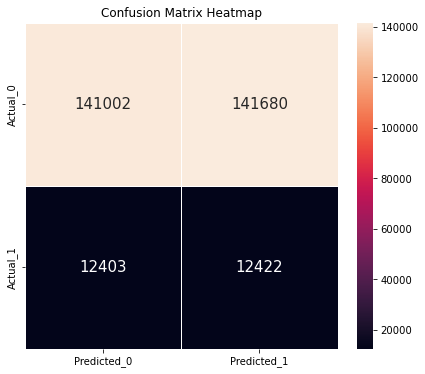

Distribution of Original Class Labels and Predicted Train and Test Class Labels


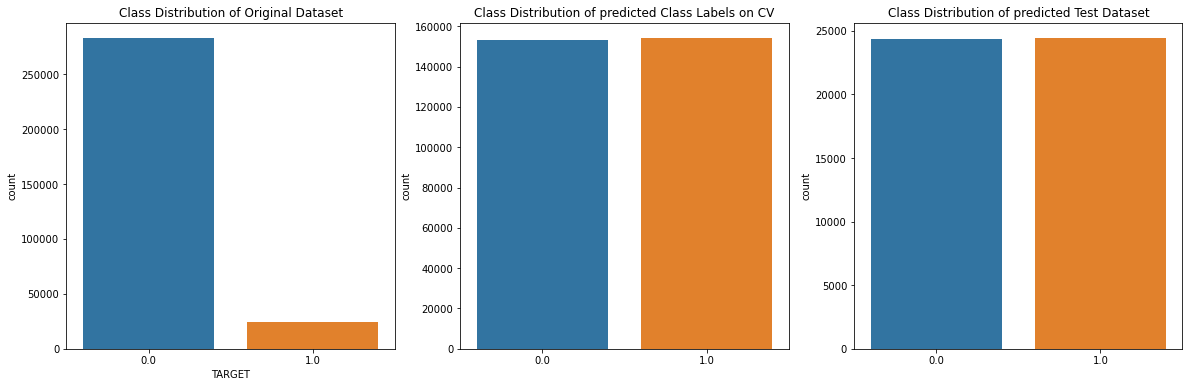

In [8]:
#predicted proability for train and test datapoints
predicted_proba_train = np.random.uniform(0, 1, len(train_data))
predicted_proba_test = np.random.uniform(0, 1, len(test_data))

print("=" * 100)
print("Training Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(target_train, predicted_proba_train)}")
print(f"\tPrecision Score = {precision_score(target_train, np.round(predicted_proba_train))}")
print(f"\tRecall Score = {recall_score(target_train, np.round(predicted_proba_train))}")
print('=' * 100)

print("Confusion Matrix of Training data:")
conf_mat = confusion_matrix(target_train, np.round(predicted_proba_train))
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (7,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
plt.show()
print('=' * 100)

print("Distribution of Original Class Labels and Predicted Train and Test Class Labels")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
plt.title('Class Distribution of Original Dataset')
sns.countplot(target_train)
plt.subplot(1,3,2)
plt.title('Class Distribution of predicted Class Labels on CV')
sns.countplot(np.round(predicted_proba_train))
plt.subplot(1,3,3)
plt.title('Class Distribution of predicted Test Dataset')
sns.countplot(np.round(predicted_proba_test))
plt.show()
print('=' * 100)

In [69]:
# #submitting the result
# pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : predicted_proba_test}).to_csv('Random_Model.csv',index = False)
# !kaggle competitions submit -c home-credit-default-risk -f Random_Model.csv -m "Random Model Predictions"
# print('Successfully submitted to Home Credit Default Risk')

Successfully submitted to Home Credit Default Risk


'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
random_model_df = pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : predicted_proba_test})
random_model_df['SK_ID_CURR'] = random_model_df['SK_ID_CURR'].astype(int)

In [11]:
random_model_df.dtypes

SK_ID_CURR      int32
TARGET        float64
dtype: object

In [12]:
random_model_df.to_csv('./submissions/Random_Model.csv',index = False)

                                                                       Private Score      Public Score

![title](images/random_model_score_.png)

- From the above Confusion Matrix, we see that it predicts almost equal numbers of Positive and Negative Class Labels. This implies the complete randomness of the model.
- From the Distributions of predicted Class Labels too, we see this behaviour.
- The AUC for the random model on training dataset comes out to be close to 0.5, and the F1-Score close to 0.14.
- The similar AUC is seen from the Test Dataset too, as seen from above submission.
- This sets a baseline for all the metrics here.

## 2.2 Dominant class model <a class="anchor" id="sec2_2"></a>
1. In this model, we will predict everything as the dominant Class, which is Class Label 0 (non-defaulter) in our case here. We will see the metrics for this model too, and again our sensible models need to perform better than this.
2. Since we are calculating the ROC-AUC value as well, so we will randomly predict a probability between 0 to 0.5 with a threshold of 0.5, so that all points get classified as 0.

Training Dataset Results:
	ROC-AUC Score = 0.5004273653769836
	Precision Score = 0.0
	Recall Score = 0.0
Confusion Matrix of Training data:


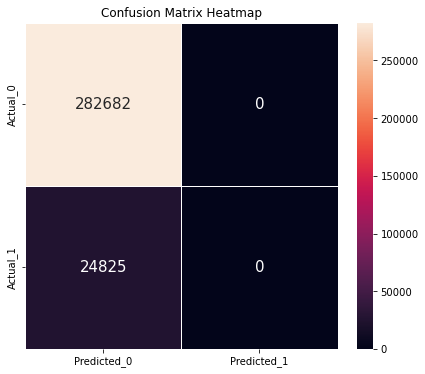

Distribution of Original Class Labels and Predicted Train and Test Class Labels


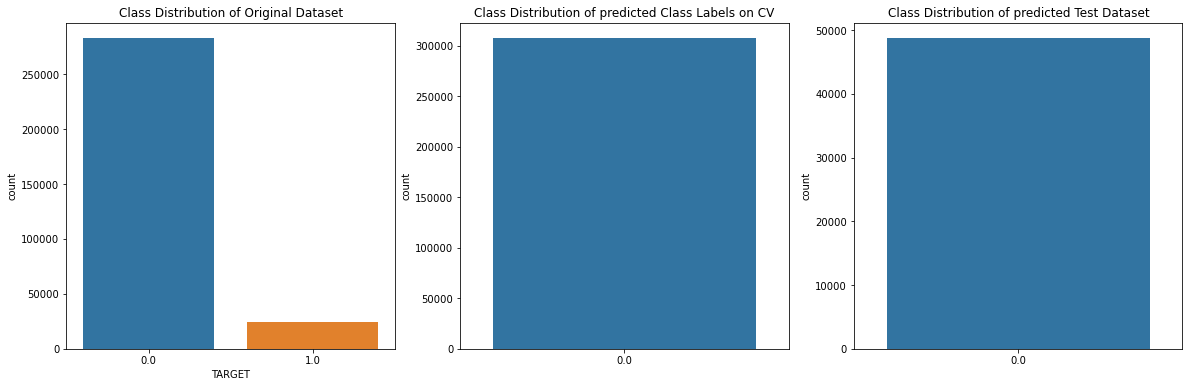

In [13]:
#predicting everything with probability less than 0.5, i.e majority class
predicted_proba_train = np.random.uniform(0, 0.5, len(train_data))
predicted_proba_test = np.random.uniform(0, 0.5, len(test_data))

print("=" * 100)
print("Training Dataset Results:")
print(f"\tROC-AUC Score = {roc_auc_score(target_train, predicted_proba_train)}")
print(f"\tPrecision Score = {precision_score(target_train, np.round(predicted_proba_train))}")
print(f"\tRecall Score = {recall_score(target_train, np.round(predicted_proba_train))}")
print('=' * 100)

print("Confusion Matrix of Training data:")
conf_mat = confusion_matrix(target_train, np.round(predicted_proba_train))
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (7,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
plt.show()
print('=' * 100)

print("Distribution of Original Class Labels and Predicted Train and Test Class Labels")
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
plt.title('Class Distribution of Original Dataset')
sns.countplot(target_train)
plt.subplot(1,3,2)
plt.title('Class Distribution of predicted Class Labels on CV')
sns.countplot(np.round(predicted_proba_train))
plt.subplot(1,3,3)
plt.title('Class Distribution of predicted Test Dataset')
sns.countplot(np.round(predicted_proba_test))
plt.show()
print('=' * 100)

In [14]:
dominant_model_df = pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : predicted_proba_test})
dominant_model_df['SK_ID_CURR'] = dominant_model_df['SK_ID_CURR'].astype(int)

In [15]:
random_model_df.dtypes

SK_ID_CURR      int32
TARGET        float64
dtype: object

In [16]:
dominant_model_df.to_csv('./submissions/Dominant_Class_Model.csv',index = False)

|        Model         | Private Score | Public Score |
|----------------------|---------------|--------------|
| Dominant_Class_Model |   0.49054     |   0.50009    |
| Random_Model         |   0.49735     |   0.48234    |

![title](images/random_dominant_score.png)

- From the above results, we observe that again the AUC remains somewhat the same, which is 0.5.
- However, the F1-Score is now 0, because we are not predicting anything as a positive class.
- The confusion matrix also shows all points as negative, i.e it has high number of false negtives, but zero false positives.

## 2.3 Logistic Regression L2 Regularization <a class="anchor" id="sec2_3"></a>
- In this section, we will use SGDClassifier with log-loss and l2 penalty. We will use GridSearchCV for Hyperparameter Optimization.
- We haven't split the data into train and cv yet. We will create the cross-validation data on the fly, i.e during hyperparameter tuning.
- For overall predictions on CV, we will use Stratified K-Fold method with predictions as Out-of-fold predictions.
- Since we are optimizing the hyperparameters for AUC and also this is the case of imbalanced dataset, we will tune the threshold for best TPR and least TPR, by using J-Statistic.

Doing Randomized Search CV on Classifier with 15 random initializations...
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Done.
Time elapsed = 0:04:13.407590


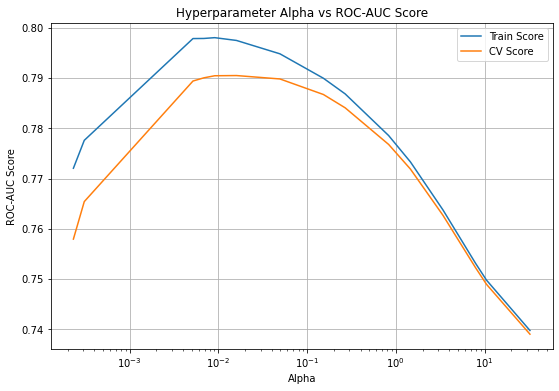

In [18]:
params = {
    'loss' : 'log',
    'penalty' : 'l2',
    'random_state' : 98,
    'class_weight' : 'balanced',
    'n_jobs' : -1
}
clf = SGDClassifier(**params)
hyperparams = {'alpha' : np.logspace(-4,2)}

sgd_lr_l2 = modelling(clf, x_train_std, y_train, x_test_std)

#lets do randomized search cv first
#if set n_jobs=-1, will send error with memory: can't allocate xx G data
#so don't use all cores
sgd_lr_l2.random_search_cv(hyperparams, n_iter = 15, n_jobs = 6) 


#visualizing the cv results
cv_results = sgd_lr_l2.tuning_results
cv_results = cv_results.sort_values('param_alpha')

#plotting the train and cv scores
plt.figure(figsize = (9,6))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], label = 'Train Score')
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], label = 'CV Score')
plt.title('Hyperparameter Alpha vs ROC-AUC Score')
plt.xlabel('Alpha')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()
plt.xscale('log')
plt.show()

Fitting Classifier on best parameters

4-Fold Cross Validation
	Fitting Fold 1
	Fitting Fold 2
	Fitting Fold 3
	Fitting Fold 4
Done.
Time elapsed = 0:00:56.374000

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.4757699396726839

Train Results:
	ROC-AUC Score = 0.797013753023273
	Precision Score = 0.1816067944903147
	Recall Score = 0.7424773413897281
CV Results:
	ROC-AUC Score = 0.7904871750921737
	Precision Score = 0.17901118758208012
	Recall Score = 0.7302719033232629
Confusion Matrix of CV data:


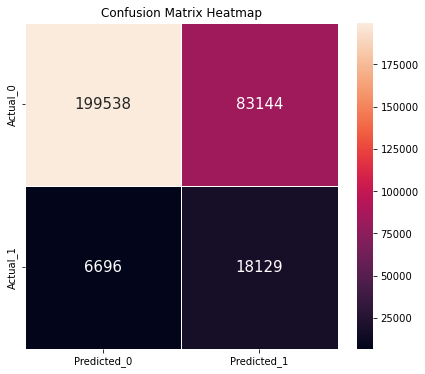

Distribution of Original Class Labels and Predicted CV and Test Class Labels


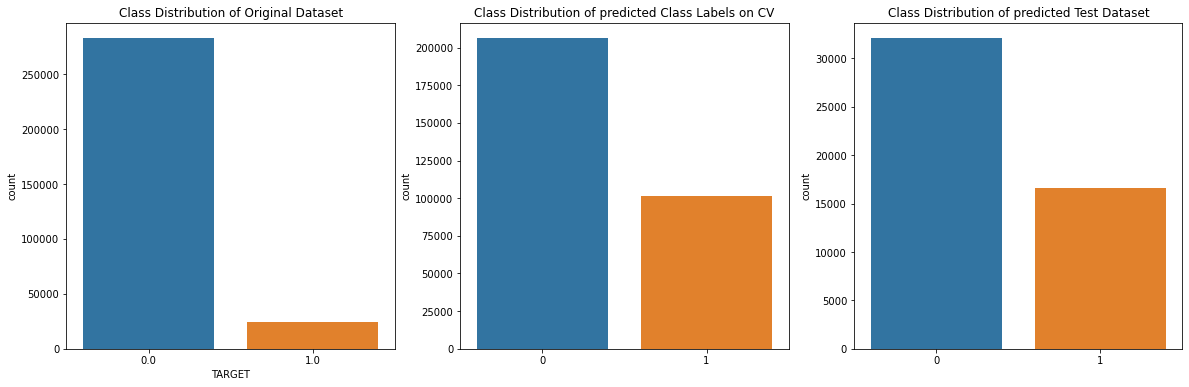

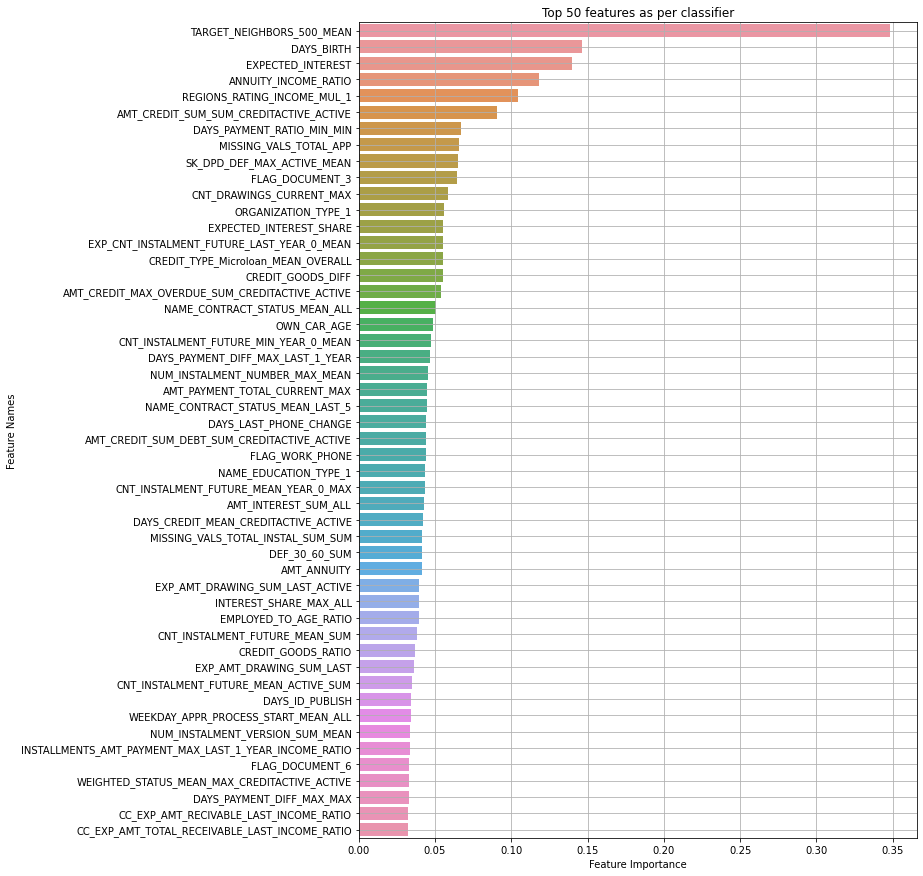

In [19]:
#training on best parameters
sgd_lr_l2.train_on_best_params()
#showing the results
sgd_lr_l2.results_on_best_params('linear')
#plotting feature importances
sgd_lr_l2.feat_importances_show(train_data.columns, num_features = 50)

In [20]:
LogReg_l2_model_df = pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : sgd_lr_l2.test_preds_probas})
LogReg_l2_model_df['SK_ID_CURR'] = LogReg_l2_model_df['SK_ID_CURR'].astype(int)
LogReg_l2_model_df.to_csv('./submissions/SGD_LR_L2_penalty.csv',index = False)

|        Model       | Private Score | Public Score |
|--------------------|---------------|--------------|
| SGD_LR_L2_penalty  |   0.77894     |   0.78355    |

![title](images/SGD_LR_L2_penalty.png)

In [21]:
with open('./data/SGD_LR_L2_Penalty_CV_Preds.pkl', 'wb') as f:
    pickle.dump(sgd_lr_l2.cv_preds_probas, f)
with open('./data/SGD_LR_L2_Penalty_Test_Preds.pkl', 'wb') as f:
    pickle.dump(sgd_lr_l2.test_preds_probas, f)
with open('./data/SGD_LR_L2_Penalty_Model.pkl', 'wb') as f:
    pickle.dump(sgd_lr_l2.best_model, f)

**Results Discussion**

1. We first tuned the hyperparameter 'alpha' for Logistic Regression using RandomizedSearchCV, with 4-fold Cross-Validation.
2. We then used the best obtained model to fit on the training dataset.
    - From the AUC Scores, we see that the Train and CV AUC Scores are very much close to each other. This implies not much of an overfit.
    - The test AUC as per Kaggle Comes out to be a little less than CV AUC. There isn't a big difference between the CV and test AUC, this implies that the CV and Test dataset are very much similar.
    - The optimal threshold for decision for probability is 0.47 which is close to 0.5. This is because Logistic Regression actually returns true class probability inherently.
    - From the confusion matrix, we see that there are lots of False Positive Results. While the number of False Negatives are actually lower.
    - We see that the precision of our model is very low. However the recall value is actually good. This is what we want, i.e. no Defaulter should be missed even if some non-defaulters get classified as Defaulters, because then they may apply again, but if a Defaulter gets missed by the model, then that could cause lots of loss for the company.
    - If we look at the distribution of predicted class labels vs actual class labels, we see that there are lots more positive class labels predicted than there actually are. This again implies The low value of precision.
    - We also see that the predicted class labels among the CV and Test Datasets follow very similar distribution, which implies that the model is performing similarly on both CV and Test Data.
    - We have plotted the top 50 features as per the classifier. The highest scoring feature comes out to be the Mean of 500 Neighbors' Target values. We also see that another engineered feature, i.e. expected interest also scores quite high. This means that our generated features are actually helping in classification task.


## 2.4 Linear SVM <a class="anchor" id="sec2_4"></a>
In this section, we will again train an SGDClassifier with L2 penalty but with hinge loss, for the case of Linear SVM. We won't be using Kernel SVM because of the high train time complexity, as the number of datapoints is very high in our case.

Doing Randomized Search CV on Classifier with 15 random initializations...
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Done.
Time elapsed = 0:06:04.187286


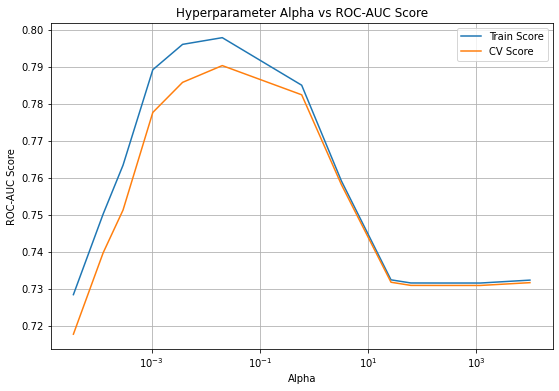

In [22]:
params = {
    'loss' : 'hinge',
    'class_weight' : 'balanced',
    'random_state' : 129,
    'n_jobs' : -1
}
clf = SGDClassifier(**params)
hyperparams = {
    'alpha' : np.logspace(-5,4) 
}
linear_svm = modelling(clf, x_train_std, y_train, x_test_std, calibration = True)

#lets do randomized search cv first
linear_svm.random_search_cv(hyperparams, n_iter = 15, n_jobs = 6, random_state = 693)

#visualizing the cv results
cv_results = linear_svm.tuning_results
cv_results = cv_results.sort_values('param_alpha')

#plotting the train and cv scores
plt.figure(figsize = (9,6))
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], label = 'Train Score')
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], label = 'CV Score')
plt.title('Hyperparameter Alpha vs ROC-AUC Score')
plt.xlabel('Alpha')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()
plt.xscale('log')
plt.show()

Fitting Classifier on best parameters

4-Fold Cross Validation
	Fitting Fold 1
	Fitting Fold 2
	Fitting Fold 3
	Fitting Fold 4
Done.
Time elapsed = 0:04:01.878000

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.07807758049442576

Train Results:
	ROC-AUC Score = 0.7980842935520804
	Precision Score = 0.1796175517134918
	Recall Score = 0.7499295065458207
CV Results:
	ROC-AUC Score = 0.7911491768177968
	Precision Score = 0.1779102391099634
	Recall Score = 0.738207452165156
Confusion Matrix of CV data:


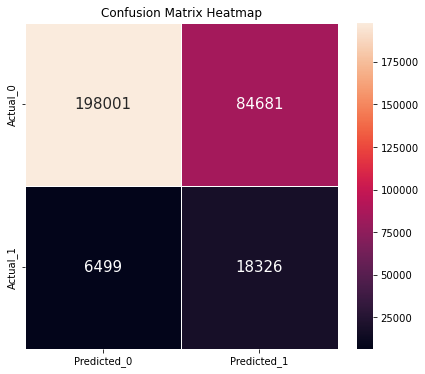

Distribution of Original Class Labels and Predicted CV and Test Class Labels


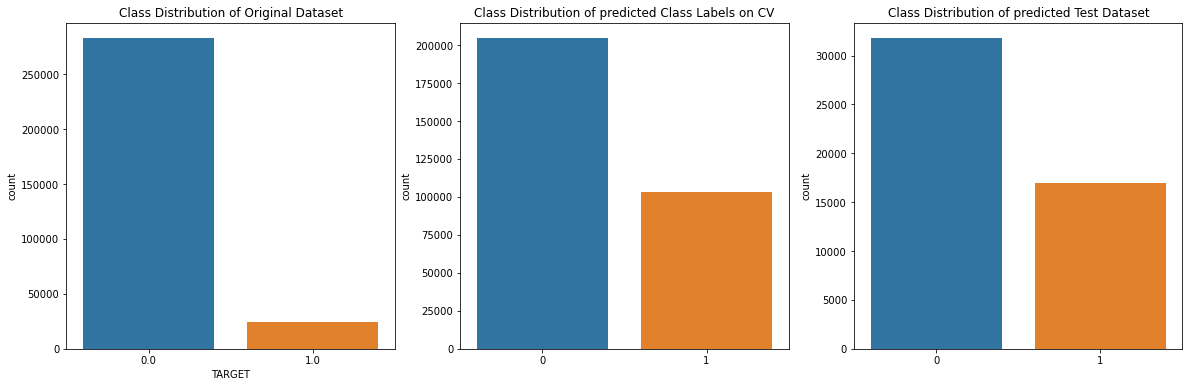

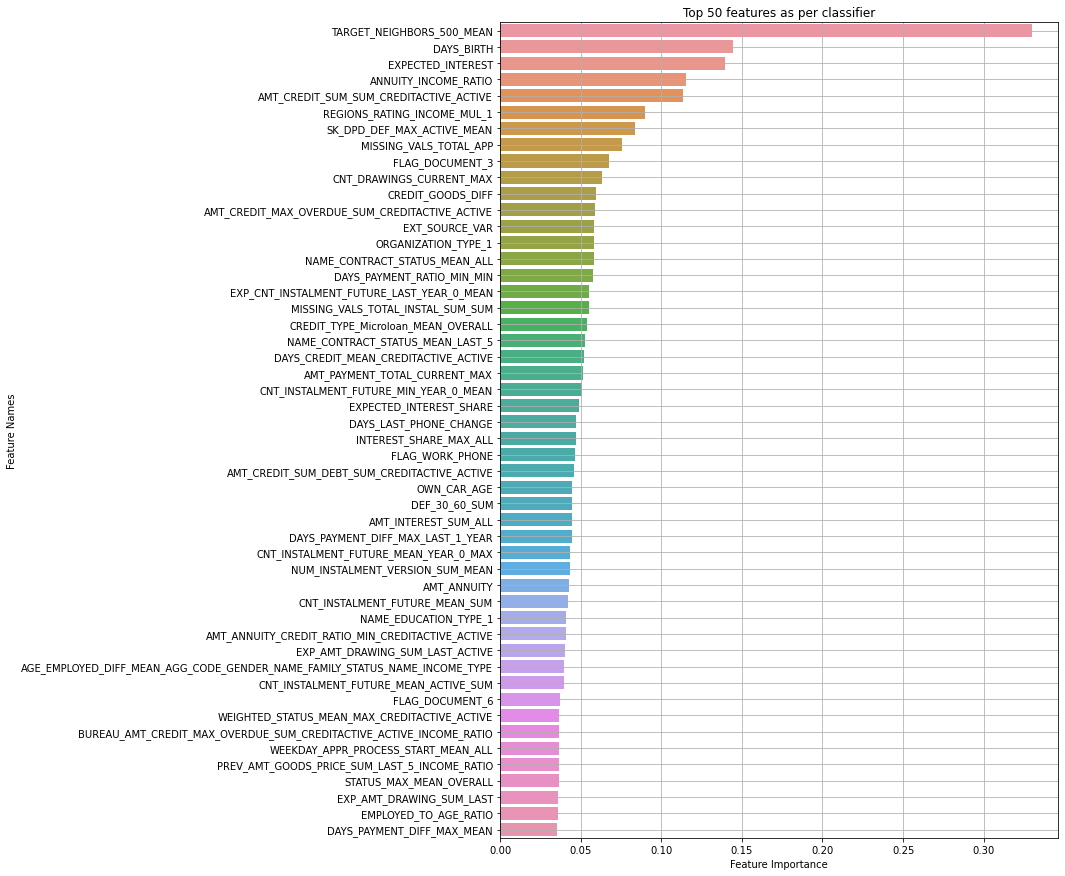

In [24]:
#training on best parameters
linear_svm.train_on_best_params()
#showing the results
linear_svm.results_on_best_params('linear')
#plotting feature importances
linear_svm.feat_importances_show(train_data.columns, num_features = 50)

In [25]:
Linear_SVM_model_df = pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : linear_svm.test_preds_probas})
Linear_SVM_model_df['SK_ID_CURR'] = Linear_SVM_model_df['SK_ID_CURR'].astype(int)
Linear_SVM_model_df.to_csv('./submissions/SGD_Linear_SVM.csv',index = False)

|        Model       | Private Score | Public Score |
|--------------------|---------------|--------------|
| SGD_Linear_SVM     |   0.77924     |   0.78397    |

![title](images/SGD_Linear_SVM.png)

In [26]:
with open('./data/SGD_Linear_SVM_CV_Preds.pkl', 'wb') as f:
    pickle.dump(linear_svm.cv_preds_probas, f)
with open('./data/SGD_Linear_SVM_Test_Preds.pkl', 'wb') as f:
    pickle.dump(linear_svm.test_preds_probas, f)
with open('./data/SGD_Linear_SVM_Model.pkl', 'wb') as f:
    pickle.dump(linear_svm.best_model, f)

**Results Discussion**

1. The results for Linear SVM without dual formulation look very similar to the Logistic Regression Results. However, there is a very slight improvement in performance.
2. Both the Train and CV AUC Scores for Linear SVM are slightly higher than that of Logistic Regression. The same can be seen from the Test AUC aswell, from the Kaggle.
3. One interesting thing to note here is that the threshold probability comes out to be as low as 0.07.
4. The Precision and Recall values are also almost the same, just slightly higher for Logisitc regression though.
5. From the Confusion Matrix, we observe that the True Positives for Linear SVM are slightly lesser than that of Logistic Regression.
6. The top 50 important features are also almost identical to the Logistic Regression.

Thus, we can conclude that the Logistic Regression and Linear SVM are behaving very similarly, as expected.

## 2.5 Random Forest Classifier <a class="anchor" id="sec2_5"></a>
In this section, we will use Bagging technique and train a Random Forest Classifier. We will be using Randomized Search technique to tune some of the hyperparameters of the RandomForestClassifier.

In [27]:
params = {
    'n_jobs' : -1,
    'random_state' : 210,
    'class_weight' : 'balanced_subsample',
    'verbose' : 0
}
clf = RandomForestClassifier(**params)

# hyperparams = {
#     'n_estimators' : list(range(500, 1500)),
#     'max_depth' : list(range(10,30)),
#     'min_samples_split' : list(range(5,50)),
#     'min_samples_leaf' : list(range(2,50)),
#     'max_samples' : uniform(0,1)   
# }

#narrower search
hyperparams = {
    'n_estimators' : list(range(1100, 1500)),
    'max_depth' : list(range(15,25)),
    'min_samples_split' : list(range(30,50)),
    'min_samples_leaf' : list(range(15,30)),
    'max_samples' : uniform(0,1)   
}

rf = modelling(clf, x_train_std, y_train, x_test_std)

#lets do randomized search cv first
rf.random_search_cv(hyperparams, n_iter = 10, n_jobs = -1, random_state = 4281)

Doing Randomized Search CV on Classifier with 10 random initializations...
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Done.
Time elapsed = 3:55:25.514972


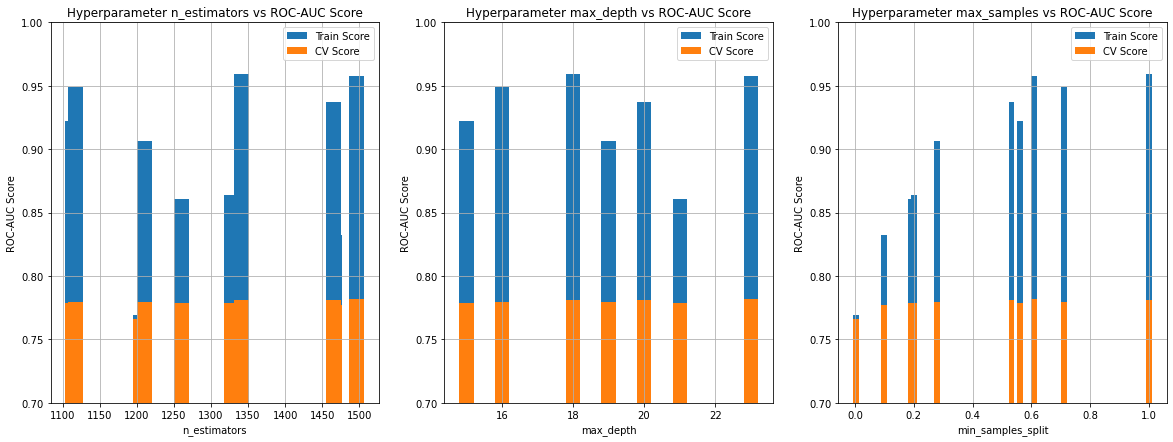

In [28]:
cv_results = rf.tuning_results

#lets plot the ROC-AUC for different Hyperparameters
plt.figure(figsize = (20,7))
plt.subplot(1,3,1)
cv_results = cv_results.sort_values('param_n_estimators')
plt.bar(cv_results['param_n_estimators'], cv_results['mean_train_score'], width = 20, label = 'Train Score')
plt.bar(cv_results['param_n_estimators'], cv_results['mean_test_score'], width = 20, label = 'CV Score')
plt.ylim(0.7,1)
plt.title('Hyperparameter n_estimators vs ROC-AUC Score')
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()

plt.subplot(1,3,2)
cv_results = cv_results.sort_values('param_max_depth')
plt.bar(cv_results['param_max_depth'], cv_results['mean_train_score'], width = 0.4, label = 'Train Score')
plt.bar(cv_results['param_max_depth'], cv_results['mean_test_score'], width = 0.4, label = 'CV Score')
plt.ylim(0.7,1)
plt.title('Hyperparameter max_depth vs ROC-AUC Score')
plt.xlabel('max_depth')
plt.ylabel('ROC-AUC Score')
plt.legend()
plt.grid()

plt.subplot(1,3,3)
cv_results = cv_results.sort_values('param_min_samples_split')
plt.bar(cv_results['param_max_samples'], cv_results['mean_train_score'], width = 0.02, label = 'Train Score')
plt.bar(cv_results['param_max_samples'], cv_results['mean_test_score'], width = 0.02, label = 'CV Score')
plt.ylim(0.7,1)
plt.title('Hyperparameter max_samples vs ROC-AUC Score')
plt.xlabel('min_samples_split')
plt.ylabel('ROC-AUC Score')

plt.legend()
plt.grid()
plt.show()

In [31]:
cv_results.to_csv('./data/rf_cv_results.csv')
# cv_results=pd.read_csv('rf_cv_results.csv')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_samples,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
1,172.818499,18.803812,60.754003,2.092862,23,0.003868,29,33,1205,"{'max_depth': 23, 'max_samples': 0.00386762788...",...,0.763441,0.766001,0.003158,10,0.769282,0.769655,0.768322,0.768782,0.769010,0.000504
2,2248.117265,8.870125,94.410002,2.755005,21,0.191401,29,34,1260,"{'max_depth': 21, 'max_samples': 0.19140070731...",...,0.777263,0.779091,0.002389,7,0.860409,0.860631,0.859834,0.860617,0.860373,0.000323
5,3469.097749,13.100123,101.399250,0.738515,19,0.279677,19,35,1210,"{'max_depth': 19, 'max_samples': 0.27967732027...",...,0.778502,0.779874,0.002335,4,0.906294,0.906940,0.906530,0.906231,0.906499,0.000278
9,4373.854249,32.071679,28.145252,4.589286,23,0.609612,22,35,1496,"{'max_depth': 23, 'max_samples': 0.60961236108...",...,0.780129,0.781735,0.002229,1,0.957524,0.957660,0.957947,0.956902,0.957508,0.000382
8,6145.497248,30.303439,43.015752,2.631186,16,0.710215,17,36,1118,"{'max_depth': 16, 'max_samples': 0.71021498401...",...,0.777560,0.779294,0.002115,5,0.949064,0.950022,0.949825,0.948836,0.949437,0.000498


In [32]:
cv_results['Train_CV_Score_Difference'] = cv_results['mean_train_score'] - cv_results['mean_test_score']

#lets look at the differences between the train and CV scores
print("Checking out the differences between Train and CV Scores for each set of hyperparameters:\n")
display(cv_results[['params', 'mean_test_score', 'mean_train_score', 'Train_CV_Score_Difference']])

Checking out the differences between Train and CV Scores for each set of hyperparameters:



,params,mean_test_score,mean_train_score,Train_CV_Score_Difference
1,"{'max_depth': 23, 'max_samples': 0.00386762788...",0.766001,0.769010,0.003010
2,"{'max_depth': 21, 'max_samples': 0.19140070731...",0.779091,0.860373,0.081281
5,"{'max_depth': 19, 'max_samples': 0.27967732027...",0.779874,0.906499,0.126624
9,"{'max_depth': 23, 'max_samples': 0.60961236108...",0.781735,0.957508,0.175773
8,"{'max_depth': 16, 'max_samples': 0.71021498401...",0.779294,0.949437,0.170142
4,"{'max_depth': 16, 'max_samples': 0.09938395385...",0.777006,0.832712,0.055706
3,"{'max_depth': 18, 'max_samples': 0.99942209291...",0.781471,0.959529,0.178059
7,"{'max_depth': 15, 'max_samples': 0.56001305553...",0.778704,0.921882,0.143179
6,"{'max_depth': 20, 'max_samples': 0.53224896818...",0.781173,0.937533,0.156359
0,"{'max_depth': 19, 'max_samples': 0.19983254792...",0.779115,0.863697,0.084582


We observe that the minimum gap between Train and CV Score is 0.003004, the second minimum is 0.55537. Because the second minimum set has higher train score, I will check the both sets. 

In [34]:
cv_results['params'][1]
# cv_results.iloc[0]

{'max_depth': 23,
 'max_samples': 0.003867627880455915,
 'min_samples_leaf': 29,
 'min_samples_split': 33,
 'n_estimators': 1205}

In [ ]:
# #because I reload the notebook, the rf from the random search cell is lost, so I need to initialize the rf model again
# params = {
#     'n_jobs' : -1,
#     'random_state' : 210,
#     'class_weight' : 'balanced_subsample',
#     'verbose' : 0
# }
# clf = RandomForestClassifier(**params)
# rf = modelling(clf, x_train_std, y_train, x_test_std)

Fitting Classifier on best parameters

4-Fold Cross Validation
	Fitting Fold 1
	Fitting Fold 2
	Fitting Fold 3
	Fitting Fold 4
Done.
Time elapsed = 0:01:37.565001

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.33303026774676714

Train Results:
	ROC-AUC Score = 0.7696044579124289
	Precision Score = 0.1709197776937178
	Recall Score = 0.7098489425981873
CV Results:
	ROC-AUC Score = 0.7659740326603871
	Precision Score = 0.16890447849879722
	Recall Score = 0.7099295065458208
Confusion Matrix of CV data:


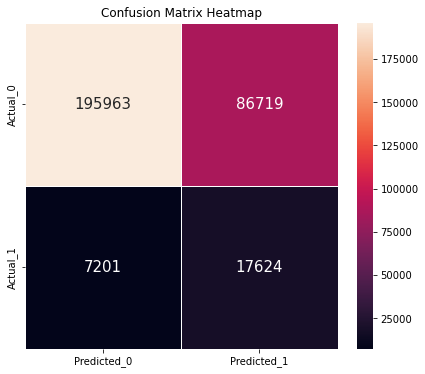

Distribution of Original Class Labels and Predicted CV and Test Class Labels


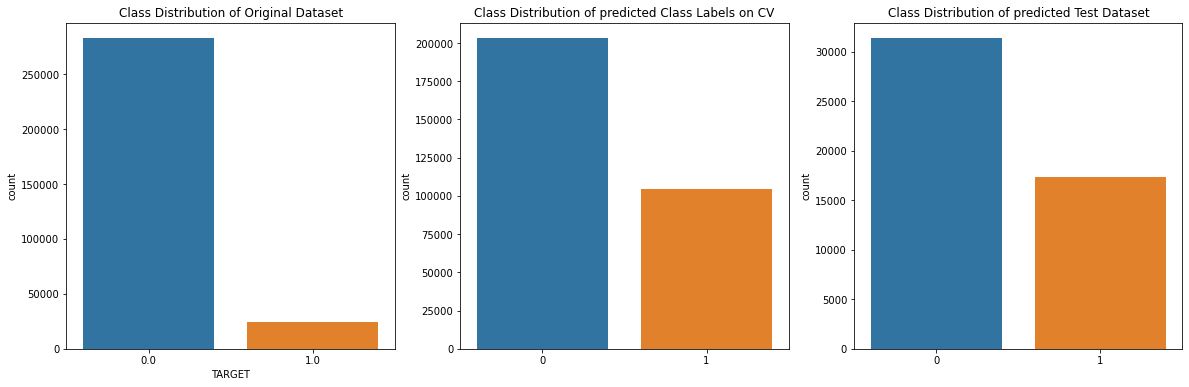

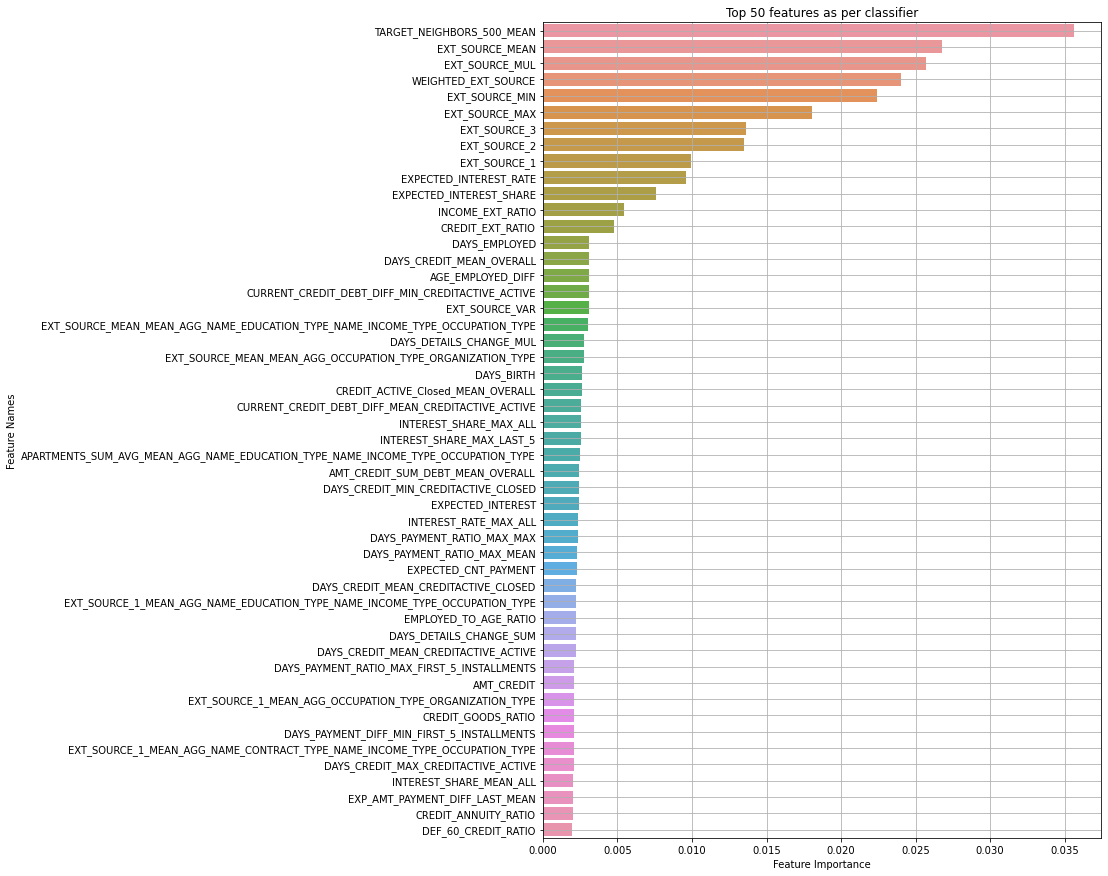

In [35]:
#reinstantiating the best model of rf class with these parameters
rf.best_model = RandomForestClassifier(class_weight = 'balanced_subsample', max_depth = 23,
                                       max_samples = 0.0038676, min_samples_leaf = 29,
                                       min_samples_split = 33, n_estimators = 1205, n_jobs = -1,
                                       random_state = 210, verbose = 0)
#training on best parameters
rf.train_on_best_params()
#showing the results
rf.results_on_best_params('random_forest')
#plotting feature importances
rf.feat_importances_show(train_data.columns, num_features = 50)

In [36]:
#saving the result
Random_Forest_model_df = pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : rf.test_preds_probas})
Random_Forest_model_df['SK_ID_CURR'] = Random_Forest_model_df['SK_ID_CURR'].astype(int)
Random_Forest_model_df.to_csv('./submissions/Random_Forest_cv0.csv',index = False)

In [ ]:
cv_results['params'][5]

Fitting Classifier on best parameters

4-Fold Cross Validation
	Fitting Fold 1
	Fitting Fold 2
	Fitting Fold 3
	Fitting Fold 4
Done.
Time elapsed = 0:07:24.525001

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.30622384506817973

Train Results:
	ROC-AUC Score = 0.831314053369661
	Precision Score = 0.18841988992003625
	Recall Score = 0.8039476334340383
CV Results:
	ROC-AUC Score = 0.7769832016109426
	Precision Score = 0.17255625372302608
	Recall Score = 0.7234642497482376
Confusion Matrix of CV data:


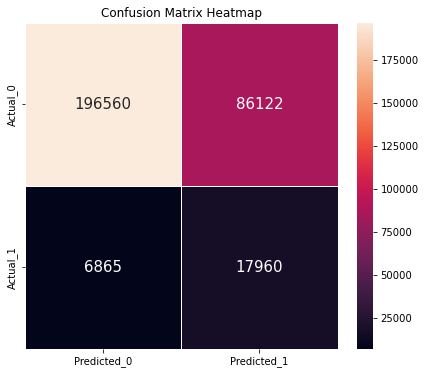

Distribution of Original Class Labels and Predicted CV and Test Class Labels


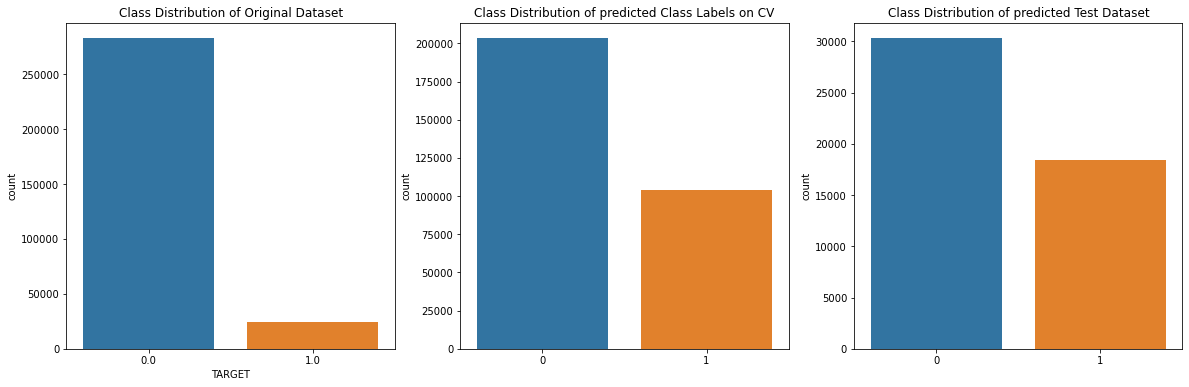

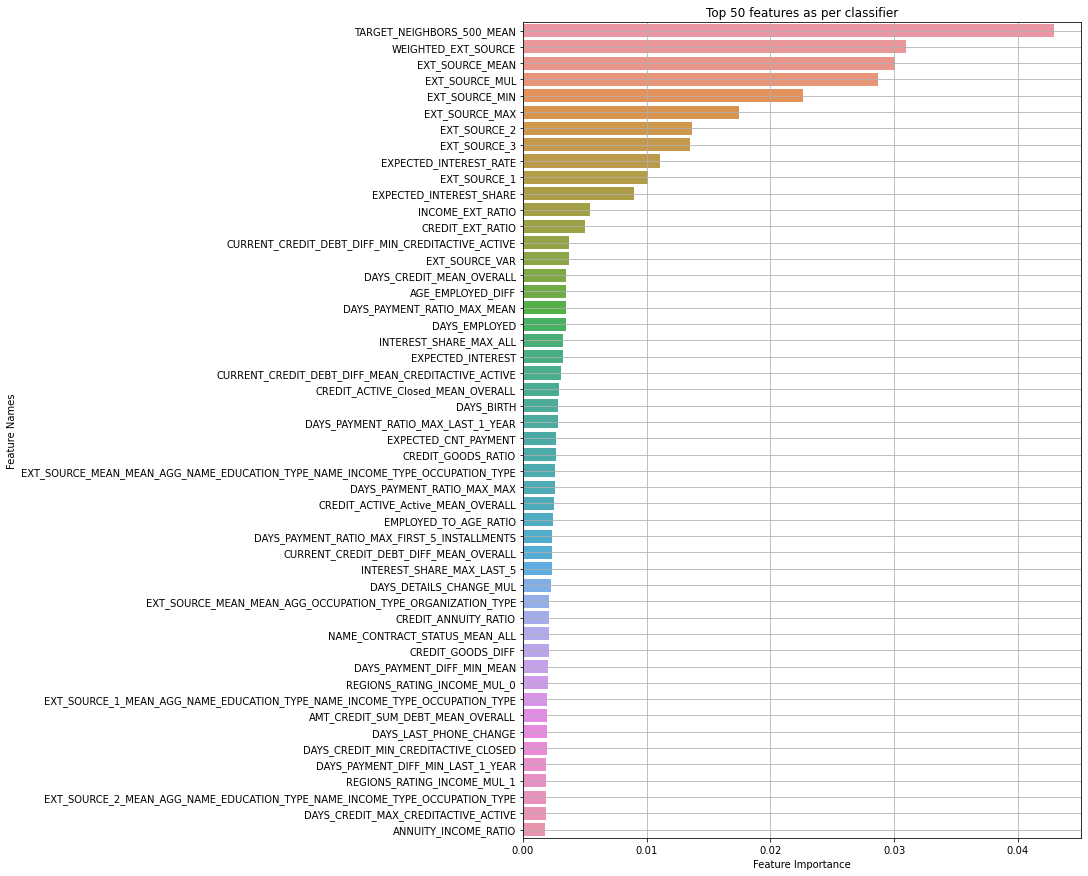

In [38]:
#reinstantiating the best model of rf class with these parameters
rf.best_model = RandomForestClassifier(class_weight = 'balanced_subsample', max_depth = 16,
                                       max_samples = 0.09938395, min_samples_leaf = 22,
                                       min_samples_split = 37, n_estimators = 1466, n_jobs = -1,
                                       random_state = 210, verbose = 0)
#training on best parameters
rf.train_on_best_params()
#showing the results
rf.results_on_best_params('random_forest')
#plotting feature importances
rf.feat_importances_show(train_data.columns, num_features = 50)

In [39]:
#saving the result
Random_Forest_model_df = pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : rf.test_preds_probas})
Random_Forest_model_df['SK_ID_CURR'] = Random_Forest_model_df['SK_ID_CURR'].astype(int)
Random_Forest_model_df.to_csv('./submissions/Random_Forest_cv5.csv',index = False)

Fitting Classifier on best parameters

4-Fold Cross Validation
	Fitting Fold 1
	Fitting Fold 2
	Fitting Fold 3
	Fitting Fold 4
Done.
Time elapsed = 0:07:37.412001

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.3155439666436208

Train Results:
	ROC-AUC Score = 0.8323048475402987
	Precision Score = 0.19064941546848904
	Recall Score = 0.8001208459214502
CV Results:
	ROC-AUC Score = 0.777431915513504
	Precision Score = 0.1720209045844061
	Recall Score = 0.721289023162135
Confusion Matrix of CV data:


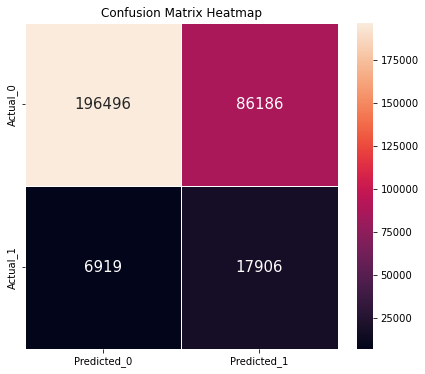

Distribution of Original Class Labels and Predicted CV and Test Class Labels


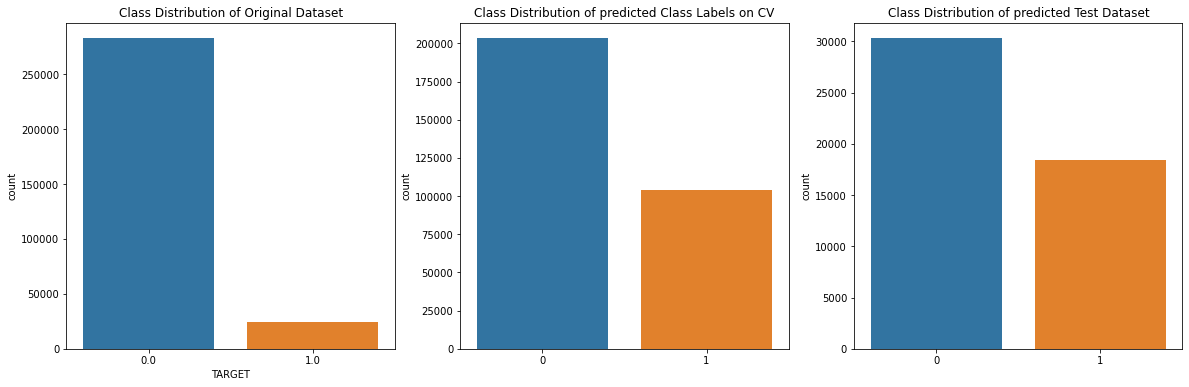

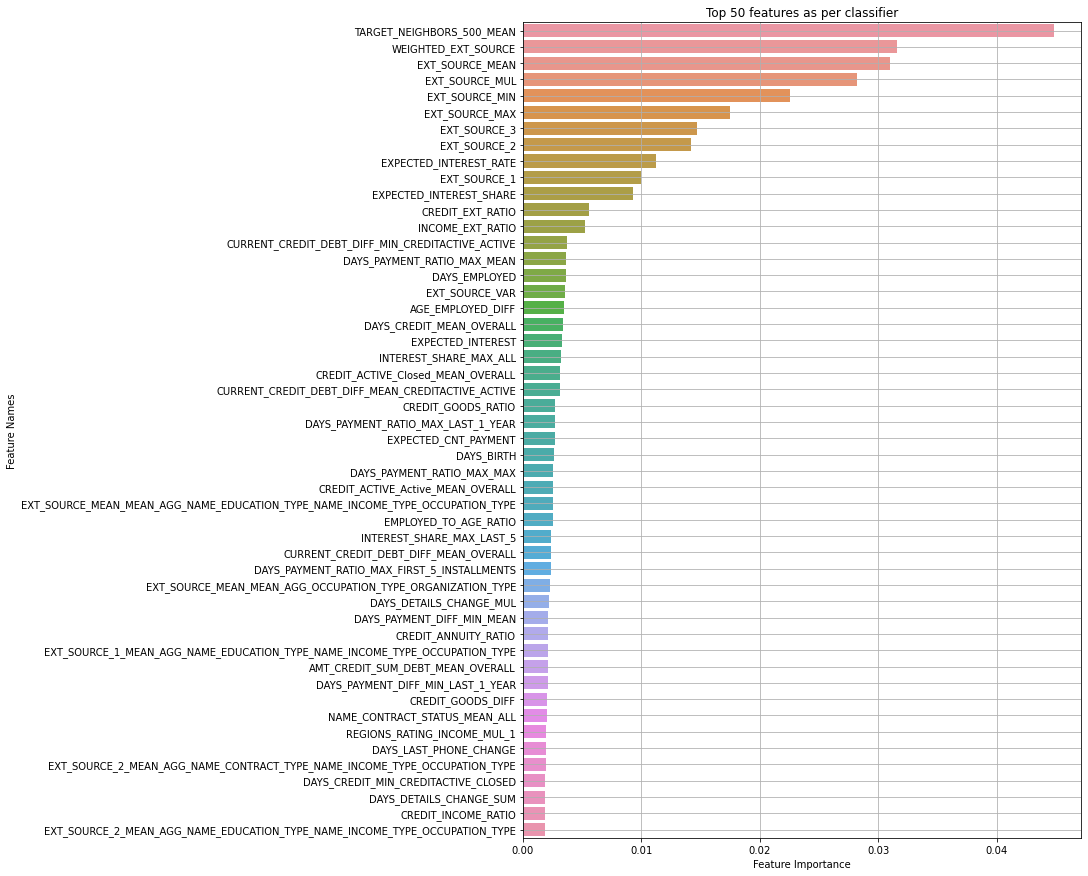

In [40]:
#reinstantiating the best model of rf class with these parameters
rf.best_model = RandomForestClassifier(class_weight = 'balanced_subsample', max_depth = 19,
                                       max_samples = 0.105493, min_samples_leaf = 26,
                                       min_samples_split = 44, n_estimators = 1403, n_jobs = -1,
                                       random_state = 210, verbose = 0)
#training on best parameters
rf.train_on_best_params()
#showing the results
rf.results_on_best_params('random_forest')
#plotting feature importances
rf.feat_importances_show(train_data.columns, num_features = 50)

In [41]:
Random_Forest_model_df = pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : rf.test_preds_probas})
Random_Forest_model_df['SK_ID_CURR'] = Random_Forest_model_df['SK_ID_CURR'].astype(int)
Random_Forest_model_df.to_csv('./submissions/Random_Forest_others.csv',index = False)

|        Model       | Private Score | Public Score |
|--------------------|---------------|--------------|
| Random_Forest_cv0  |   0.75370     |   0.76250    |
| Random_Forest_cv5  |   0.76360     |   0.77055    |
| Random_Forest_others  |   0.76396     |   0.77103    |

Random_Forest_cv0.

![title](images/Random_Forest_cv0.png)

Random_Forest_cv5.

![title](images/Random_Forest_cv5.png)

Random_Forest_others.

![title](images/Random_Forest_others.png)

In [42]:
with open('./data/Random_Forest_CV_Preds.pkl', 'wb') as f:
    pickle.dump(rf.cv_preds_probas, f)

with open('./data/Random_Forest_Test_Preds.pkl', 'wb') as f:
    pickle.dump(rf.test_preds_probas, f)

with open('./data/Random_Forest_Model.pkl', 'wb') as f:
    pickle.dump(rf.best_model, f)

## 2.6 ExtraTreesClassifier <a class="anchor" id="sec2_6"></a>
This classifier is very much similar to the RandomForestClassifier, except that it only looks at only some random values for Information Gain while splitting the data for numeric features.

In [44]:
params = {
    'n_jobs' : 6,
    'bootstrap' : True,
    'random_state' : 210,
    'class_weight' : 'balanced_subsample',
    'verbose' : 0
}
clf = ExtraTreesClassifier(**params)
# hyperparams = {
#     'n_estimators' : list(range(500, 1500)),
#     'max_depth' : list(range(10,30)),
#     'min_samples_split' : list(range(5,20)),
#     'min_samples_leaf' : list(range(2,20)),
#     'max_samples' : uniform(0,1)   
# }

hyperparams = {
    'n_estimators' : list(range(800, 1200)),
    'max_depth' : list(range(15,30)),
    'min_samples_split' : list(range(5,20)),
    'min_samples_leaf' : list(range(10,20)),
    'max_samples' : uniform(0,1)   
}

extra_trees = modelling(clf, x_train_std, y_train, x_test_std)

#lets do randomized search cv first
extra_trees.random_search_cv(hyperparams, n_iter = 10, n_jobs = 6, random_state = 4281)

Doing Randomized Search CV on Classifier with 10 random initializations...
Fitting 4 folds for each of 10 candidates, totalling 40 fits


exception calling callback for <Future at 0x2909d645bb0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "D:\chengxu\Anaconda\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "D:\chengxu\Anaconda\lib\site-packages\joblib\parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "D:\chengxu\Anaconda\lib\site-packages\joblib\parallel.py", line 794, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "D:\chengxu\Anaconda\lib\site-packages\joblib\parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "D:\chengxu\Anaconda\lib\site-packages\joblib\parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "D:\chengxu\Anaconda\lib\site-packages\joblib\_parallel_backends.py", line 531, in apply_async
    future = self._workers.submit(SafeFunction(func))
  File "D:\chengxu\Anaconda\li

KeyboardInterrupt: 

## 2.7 XGBoost GPU <a class="anchor" id="sec2_7"></a>
For both XGBoost and LightGBM boosting, we have too many hyperparameters to tune, and doing GridSearchCV or RandomizedSearchCV can be too expesive on such a big dataset for finding an optimal solution. That is why we will be using the Bayesian Optimization Technique to tune the hyperparameters, which works by looking at the results on previous hyperparameters while assigning new hyperparameters. It tries to model on the Cost Function which is dependent on all the hyperparameters.

**Bayesian Optimization**

In [45]:
def xgb_evaluation(max_depth, min_child_weight, gamma, subsample, colsample_bytree, colsample_bylevel,
                   colsample_bynode, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of XGBoost's Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.
    
    Inputs: Hyperparamters to be tuned.
        max_depth, min_child_weight, gamma, subsample, colsample_bytree, colsample_bylevel,
        colsample_bynode, reg_alpha, reg_lambda
        
    Returns:
        CV ROC-AUC Score
    '''
    params = {
        'learning_rate' : 0.01,
        'n_estimators' : 10000,
        'tree_method' : 'gpu_hist',
        'gpu_id' : 0,
        'max_depth' : int(round(max_depth)),
        'min_child_weight' : int(round(min_child_weight)),
        'subsample': subsample,
        'gamma' : gamma,
        'colsample_bytree' : colsample_bytree,
        'colsample_bylevel' : colsample_bylevel,
        'colsample_bynode' : colsample_bynode,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'random_state' : 51412
    }    
    
    #defining the Cross-Validation Strategry
    stratified_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 33)
    cv_preds = np.zeros(train_data.shape[0])
    
    #iterating over each fold, training the model, and making Out of Fold Predictions
    for train_indices, cv_indices in stratified_cv.split(train_data, target_train):
        
        x_tr = train_data.iloc[train_indices]
        y_tr = target_train.iloc[train_indices]
        x_cv = train_data.iloc[cv_indices]
        y_cv = target_train.iloc[cv_indices]
        
        xgbc = XGBClassifier(**params)
        xgbc.fit(x_tr, y_tr, eval_set= [(x_cv,y_cv)],
                        eval_metric='auc', verbose = False, early_stopping_rounds=200)
        
        cv_preds[cv_indices] = xgbc.predict_proba(x_cv, ntree_limit = xgbc.get_booster().best_ntree_limit)[:,1]
        gc.collect()   
        
    return roc_auc_score(target_train, cv_preds)

In [46]:
#defining the optimizer and the hyperparameters along with ranges of values.
bopt_xgb =  BayesianOptimization(xgb_evaluation, {'max_depth' : (5,15),
                                                  'min_child_weight' : (5,80),
                                                  'gamma' : (0.2,1),
                                                  'subsample' : (0.5,1),
                                                  'colsample_bytree' : (0.5,1),
                                                  'colsample_bylevel' : (0.3,1),
                                                  'colsample_bynode' : (0.3,1),
                                                  'reg_alpha' : (0.001, 0.3),
                                                  'reg_lambda' : (0.001, 0.3)}, 
                                 random_state = 55)

bopt_xgb.maximize(n_iter = 6, init_points = 4) #cost 2h:2min:49sec

|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8025   |  0.3652   |  0.9802   |  0.7419   |  0.394    |  10.31    |  26.42    |  0.2589   |  0.01329  |  0.5542   |
|  2        |  0.8016   |  0.837    |  0.336    |  0.8879   |  0.2073   |  11.18    |  66.4     |  0.2697   |  0.2957   |  0.7484   |
|  3        |  0.8017   |  0.5466   |  0.907    |  0.6984   |  0.7149   |  5.205    |  65.61    |  0.1295   |  0.168    |  0.8896   |
|  4        |  0.8024   |  0.5818   |  0.9356   |  0.825    |  0.7818   |  12.8     |  31.3     |  0.006878 |  0.1082   |  0.6516   |
|  5        |  0.8027   |  0.8305   |  0.4952   |  0.8452   |  0.9234   |  14.86    |  5.011    |  0.2194   |  0.2374   |  0.5385   |
|  6        |  0.806    |  0.6235   |  0.588    |  0.5098   | 

In [47]:
#extracting the best parameters
target_values = []
for result in bopt_xgb.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']
    
print("Best Hyperparameters for XGBoost are:\n")
print(best_params)

Best Hyperparameters for XGBoost are:

{'colsample_bylevel': 1.0, 'colsample_bynode': 1.0, 'colsample_bytree': 1.0, 'gamma': 1.0, 'max_depth': 5.0, 'min_child_weight': 7.364705574739114, 'reg_alpha': 0.001, 'reg_lambda': 0.001, 'subsample': 0.5}


In [51]:
#optimizer.max can replace above method
bopt_xgb.max

{'target': 0.8060150055418316,
 'params': {'colsample_bylevel': 1.0,
  'colsample_bynode': 1.0,
  'colsample_bytree': 1.0,
  'gamma': 1.0,
  'max_depth': 5.0,
  'min_child_weight': 7.364705574739114,
  'reg_alpha': 0.001,
  'reg_lambda': 0.001,
  'subsample': 0.5}}

In [56]:
params_custom = {
        'learning_rate' : 0.01,
        'n_estimators' : 10000,
        'tree_method' : 'gpu_hist',
        'gpu_id' : 0,
        'random_state' : 51412,
}
params={**params_custom, **best_params, 'max_depth': 5} #max_depth must be int
params

{'learning_rate': 0.01,
 'n_estimators': 10000,
 'tree_method': 'gpu_hist',
 'gpu_id': 0,
 'random_state': 51412,
 'colsample_bylevel': 1.0,
 'colsample_bynode': 1.0,
 'colsample_bytree': 1.0,
 'gamma': 1.0,
 'max_depth': 5,
 'min_child_weight': 7.364705574739114,
 'reg_alpha': 0.001,
 'reg_lambda': 0.001,
 'subsample': 0.5}

**Training on Optimized Hyper-parameters**

In [57]:
#training on optimized hyperparameters
# params = {
#         'learning_rate' : 0.01,
#         'n_estimators' : 10000,
#         'tree_method' : 'gpu_hist',
#         'gpu_id' : 0,
#         'max_depth' : 5,
#         'min_child_weight' : 80,
#         'subsample': 0.7748690361169297,
#         'gamma' : 0.6992119556036338,
#         'colsample_bytree' : 0.7132522544384412,
#         'colsample_bylevel' : 0.5699318202360774,
#         'colsample_bynode' : 0.7635378153900353,
#         'reg_alpha' : 0.16095798232508268,
#         'reg_lambda' : 0.03564525547115141,
#         'random_state' : 51412
#     }  
 
xgb_boosting = Boosting(train_data, target_train, test_data, params, random_state = 98, save_model_to_pickle = True)
xgb_boosting.train(booster = 'xgboost')

Fitting the xgboost on Training Data with 3 fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation

	Fold Number 1

[0]	validation_0-auc:0.75488	validation_1-auc:0.75890
[400]	validation_0-auc:0.79939	validation_1-auc:0.78865
[800]	validation_0-auc:0.82469	validation_1-auc:0.80054
[1200]	validation_0-auc:0.84024	validation_1-auc:0.80461
[1600]	validation_0-auc:0.85284	validation_1-auc:0.80628
[2000]	validation_0-auc:0.86399	validation_1-auc:0.80736
[2400]	validation_0-auc:0.87376	validation_1-auc:0.80784
[2800]	validation_0-auc:0.88289	validation_1-auc:0.80815
[3200]	validation_0-auc:0.89129	validation_1-auc:0.80822
[3269]	validation_0-auc:0.89277	validation_1-auc:0.80817

	Fold Number 2

[0]	validation_0-auc:0.75779	validation_1-auc:0.75129
[400]	validation_0-auc:0.80063	validation_1-auc:0.78199
[800]	validation_0-auc:0.82523	validation_1-auc:0.79614
[1200]	validation_0-auc:0.84092	validation_1-auc:0.80062
[1600]	validation_0-auc:0.85345	validation_1-auc:0.8026

Train Results:

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.04854641606410345

	ROC-AUC Score = 0.9009970237392284
	Precision Score = 0.26861325255781904
	Recall Score = 0.832306143001007
CV Results:
	ROC-AUC Score = 0.8055309287396647
	Precision Score = 0.15021520192048182
	Recall Score = 0.851963746223565
Confusion, Precision and Recall Matrix on CV data:


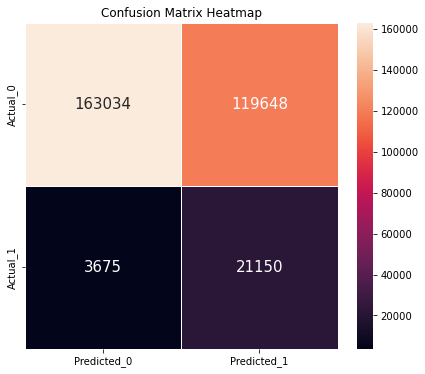

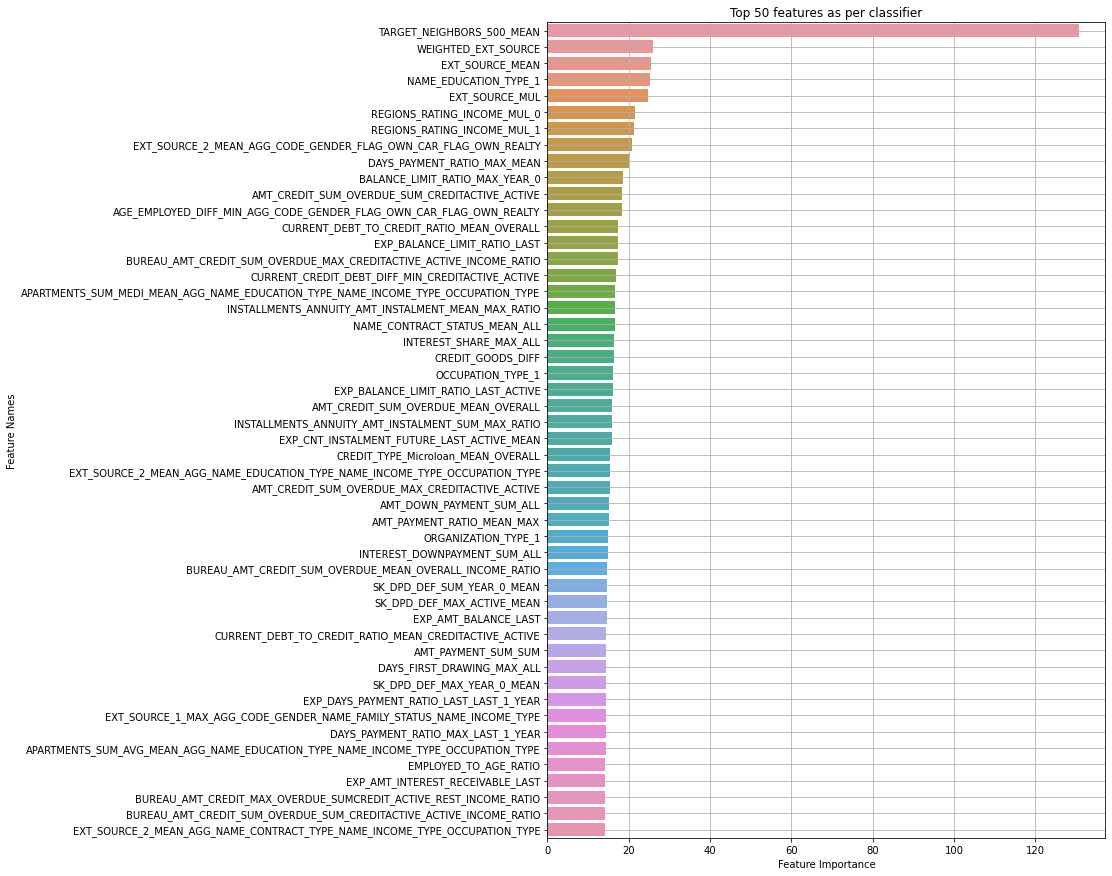

In [58]:
#displaying the results and metrics
xgb_boosting.results()
#displaying top 50 important features
xgb_boosting.feat_importances_show(50)

In [59]:
features_with_zero_importances = xgb_boosting.feature_importance[xgb_boosting.feature_importance.gain == 0]

print(f"There are {len(features_with_zero_importances)} features with Zero Gain in XGBClassifier. They are:\n")
print(features_with_zero_importances.features.values)

There are 44 features with Zero Gain in XGBClassifier. They are:

['NAME_CONTRACT_TYPE_1' 'REGION_RATING_CLIENT_W_CITY_1' 'FLAG_MOBIL'
 'NAME_EDUCATION_TYPE_0' 'NAME_CONTRACT_TYPE_0'
 'CURRENT_AMT_OVERDUE_DURATION_RATIO_MEAN_OVERALL' 'NAME_FAMILY_STATUS_0'
 'FLAG_EMP_PHONE' 'FLAG_OWN_CAR_1' 'CURRENCY_currency 4_MEAN_OVERALL'
 'DAYS_CREDIT_ENDDATE_MEAN_OVERALL'
 'APARTMENTS_SUM_AVG_MEAN_AGG_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY'
 'REGION_RATING_CLIENT_1'
 'CREDIT_TYPE_Loan for the purchase of equipment_MEAN_OVERALL'
 'CURRENT_DEBT_TO_CREDIT_RATIO_MINCREDIT_ACTIVE_REST'
 'FONDKAPREMONT_MODE_0' 'CREDIT_DURATION_MEAN_OVERALL' 'HOUSETYPE_MODE_1'
 'APARTMENTS_SUM_MEDI_MIN_AGG_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY'
 'FLAG_DOCUMENT_7' 'NAME_HOUSING_TYPE_1' 'FLAG_DOCUMENT_21'
 'NAME_TYPE_SUITE_0' 'CREDIT_TYPE_Real estate loan_MEAN_OVERALL'
 'EXT_SOURCE_3_MIN_AGG_CODE_GENDER_NAME_FAMILY_STATUS_NAME_INCOME_TYPE'
 'APARTMENTS_SUM_MEDI_MAX_AGG_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY'
 'EXT_S

In [60]:
XGB_model_df = pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : xgb_boosting.test_preds_proba_mean})
XGB_model_df['SK_ID_CURR'] = XGB_model_df['SK_ID_CURR'].astype(int)
XGB_model_df.to_csv('./submissions/XGBoost_3folds_final.csv',index = False)

|        Model         | Private Score | Public Score |
|----------------------|---------------|--------------|
| XGBoost_3folds_final |   0.79733     |   0.79921    |

![title](images/XGBoost_3folds_final.png)

In [61]:
with open('./data/xgb_imp_feats.pkl','wb') as f:
    pickle.dump(xgb_boosting.feature_importance, f)
with open('./data/xgb_cv_preds.pkl', 'wb') as f:
    pickle.dump(xgb_boosting.cv_preds_proba, f)
with open('./data/xgb_test_preds.pkl', 'wb') as f:
    pickle.dump(xgb_boosting.test_preds_proba_mean, f)

**Results Discussion**

1. The XGBoost model with optimized Hyper-parameters seems to perform better than all the models used so far, by a margin. These results are reflected both for Cross-Validation, as well as Test Scores.
2. The single model of XGBoost gives us a private Score of 0.79733 which is about top 7.6% in private leaderboard.
3. The CV and Test AUC are also very close to each other, which implies similar distribution of training and test data.
4. We notice here that the Recall Value for CV dataset is actually higher than Train Dataset, but the precision values are very low.
5. Looking at the Confusion Matrix, we see that There are very few False Negatives, but the Numbers of False Positives is quite high. This is the trade-off between the recall and precision that we have to take.
6. We have tuned the threshold by using the ROC-AUC curve, which tries to maximize the True Positive Rate (which we can see from the Confusion Matrix as well) and also to minimize the False Positive Rate, which is close to 0.047 here.

**Feature Importances**
1. The Tree Based methods give sensible feature importances. We see that the highest scoring feature according to Gini Gain is TARGET Mean of 500 neighbors feature. We see lots of features generated from EXT_SOURCE as top scoring features. Among the other features, we notice that the features generated from Categorical interactions in application_train table have also scored high by the model.
2. Among the 1236 features, we find that 44 features have exactly 0 Gini Gain, and we would be better off removing them if we were to use this classifier.

**Analysing the Feature Importances From XGBoost**

Let us analyze the feature importances of the features obtained from XGBoost Model.

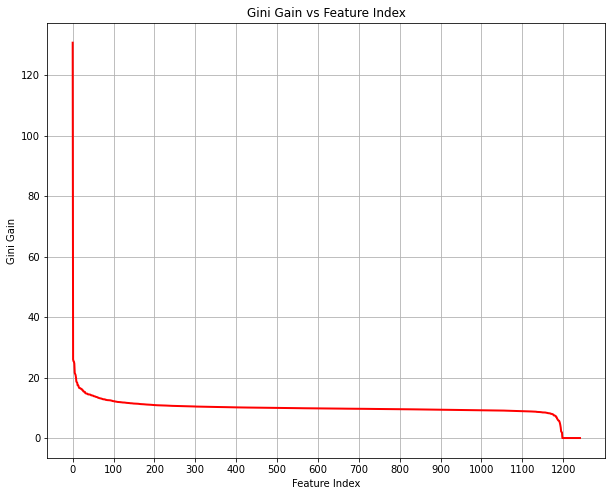

In [62]:
#plotting the importance vs feature index for the features
plt.figure(figsize = (10,8))
plt.plot(list(range(len(xgb_boosting.feature_importance))), xgb_boosting.feature_importance.gain, color = 'r', linewidth = 2)
plt.xlabel('Feature Index')
plt.ylabel('Gini Gain')
plt.xticks(list(range(0,1300,100)))
plt.grid()
plt.title("Gini Gain vs Feature Index")
plt.show()

From the above figure we notice that there is an elbow point at about 100 features, after which the gain falls very slowly. Let us try to exclude these first 100 highest scoring features, and try to observe more features.

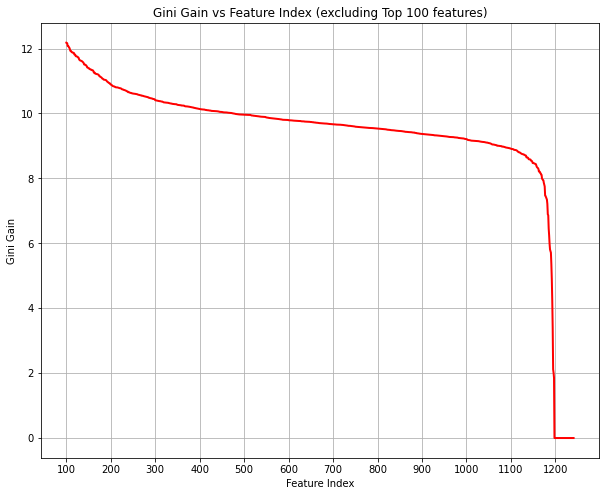

In [63]:
#plotting the importance vs feature index for the features
plt.figure(figsize = (10,8))
plt.plot(list(range(len(xgb_boosting.feature_importance)-100)), xgb_boosting.feature_importance.gain.iloc[100:], color = 'r', linewidth = 2)
plt.xlabel('Feature Index')
plt.ylabel('Gini Gain')
plt.xticks(ticks = list(range(0,1200,100)), labels = list(range(100,1300,100)))
plt.grid()
plt.title("Gini Gain vs Feature Index (excluding Top 100 features)")
plt.show()

Here again, we see a point of elbow of drop in feature importance/gini gain at feature index between 500-600 features. So we will take the top 600 features and try to model the XGBoostClassifier with same parameters on this reduced set of parameters, and compare the performance.

## 2.8 XGBoost GPU on Reduced Features <a class="anchor" id="sec2_8"></a>

In [64]:
#reducing the feature set
#taking the top 600 scoring features
train_data_600 = train_data[xgb_boosting.feature_importance.features.iloc[:600]]
test_data_600 = test_data[xgb_boosting.feature_importance.features.iloc[:600]]

print(f"Training Data Shape with reduced feature set = {train_data_600.shape}")
print(f"Test Data Shape with reduced feature set = {test_data_600.shape}")

Training Data Shape with reduced feature set = (307507, 600)
Test Data Shape with reduced feature set = (48744, 600)


**Training the model**

In [65]:
#training on the already optimized params above
xgb_boosting_600 = Boosting(train_data_600, target_train, test_data_600, params, random_state = 98, save_model_to_pickle = True)
xgb_boosting_600.train(booster = 'xgboost', pickle_name = '600feats')

Fitting the xgboost on Training Data with 3 fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation

	Fold Number 1

[0]	validation_0-auc:0.75535	validation_1-auc:0.75941
[400]	validation_0-auc:0.79894	validation_1-auc:0.78876
[800]	validation_0-auc:0.82369	validation_1-auc:0.80060
[1200]	validation_0-auc:0.83839	validation_1-auc:0.80460
[1600]	validation_0-auc:0.85020	validation_1-auc:0.80639
[2000]	validation_0-auc:0.86070	validation_1-auc:0.80722
[2400]	validation_0-auc:0.86973	validation_1-auc:0.80772
[2800]	validation_0-auc:0.87821	validation_1-auc:0.80809
[3200]	validation_0-auc:0.88589	validation_1-auc:0.80817
[3556]	validation_0-auc:0.89258	validation_1-auc:0.80821

	Fold Number 2

[0]	validation_0-auc:0.75784	validation_1-auc:0.75117
[400]	validation_0-auc:0.80011	validation_1-auc:0.78230
[800]	validation_0-auc:0.82405	validation_1-auc:0.79655
[1200]	validation_0-auc:0.83873	validation_1-auc:0.80117
[1600]	validation_0-auc:0.85061	validation_1-auc:0.8033

Train Results:

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.04608752330144246

	ROC-AUC Score = 0.8602796863474593
	Precision Score = 0.23351674756115143
	Recall Score = 0.7829607250755287
CV Results:
	ROC-AUC Score = 0.8012951862548242
	Precision Score = 0.14319551104557676
	Recall Score = 0.8645317220543807
Confusion, Precision and Recall Matrix on CV data:


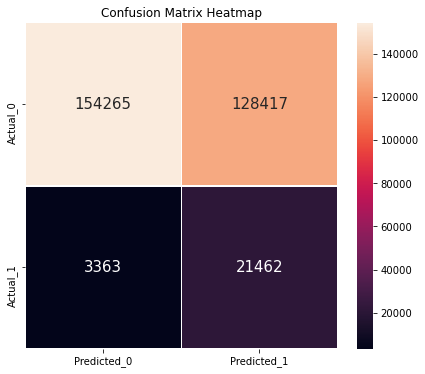

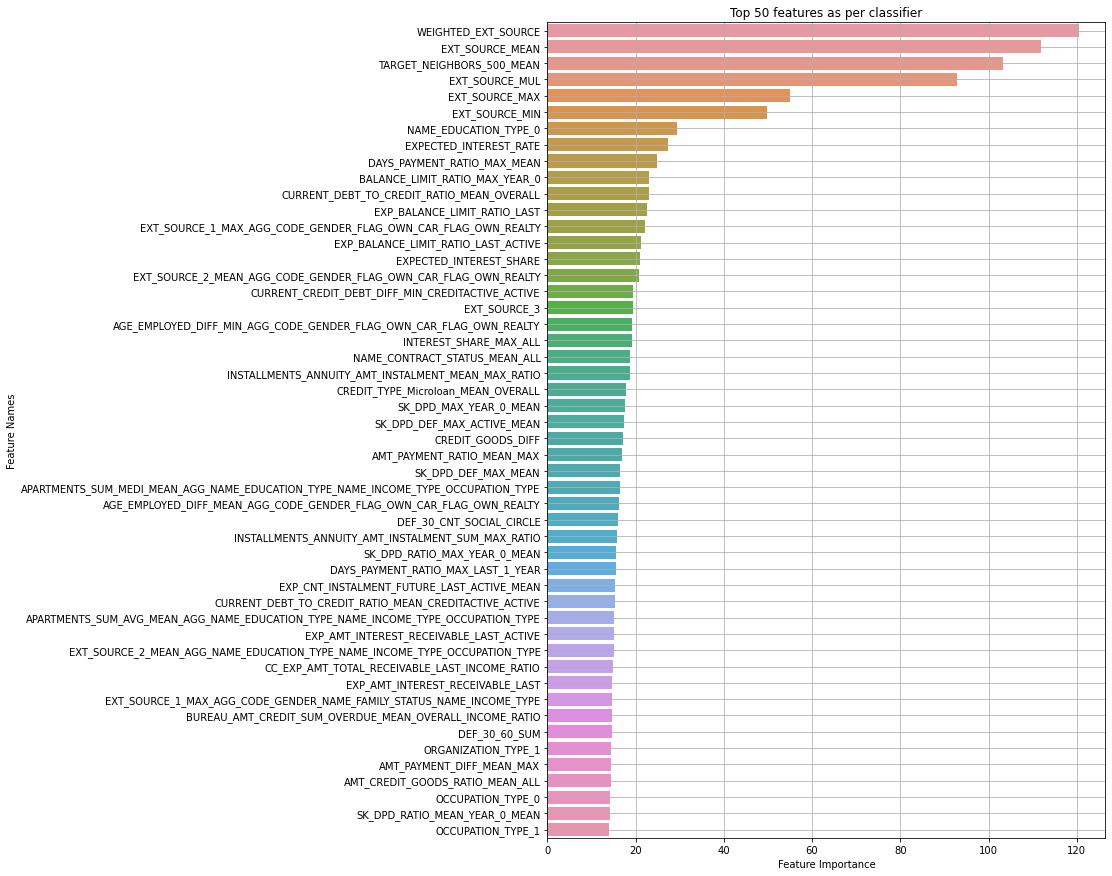

In [147]:
#displaying the results and metrics
xgb_boosting_600.results()
#displaying top 50 important features
xgb_boosting_600.feat_importances_show(50)

In [66]:
with open('./data/xgb_imp_feats_600feats.pkl','wb') as f:
    pickle.dump(xgb_boosting_600.feature_importance, f)
with open('./data/xgb_cv_preds_600feats.pkl', 'wb') as f:
    pickle.dump(xgb_boosting_600.cv_preds_proba, f)
with open('./data/xgb_test_preds_600feats.pkl', 'wb') as f:
    pickle.dump(xgb_boosting_600.test_preds_proba_mean, f)
with open('./data/Final_XGBOOST_Selected_features', 'wb') as f:
    pickle.dump(xgb_boosting_600.feature_importance.features.values, f)

In [67]:
XGB600_model_df = pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : xgb_boosting_600.test_preds_proba_mean})
XGB600_model_df['SK_ID_CURR'] = XGB600_model_df['SK_ID_CURR'].astype(int)
XGB600_model_df.to_csv('./submissions/XGBoost_600_features.csv',index = False)

|        Model         | Private Score | Public Score |
|----------------------|---------------|--------------|
| XGBoost_600_features |   0.79744     |   0.79768    |

![title](images/XGBoost_600_features.png)

**Results Discussion**

1. From the results, we observe that the gap between CV and Train ROC-AUC Score has reduced, which means a little bit lesser over-fit compared to the model with all 1236 features.
2. We also notice that the Recall has improved, while the Precision has reduced very slightly.
3. The above point can also be realised by looking at the Confusion Matrix, which reported a higher number of True Positives now.
4. The Private Score has also improved by removing the features. This implies that there might have been some noisy features, which were causing performance degradation.
5. The Feature Importances remain more or less the same.

Thus, we can conclude that by removing the feature sets, we have both improved the performance, and reduced the computaional complexity of our model.

## 2.9 LightGBM <a class="anchor" id="sec2_9"></a>
**Bayesian Optimization**

In [68]:
def lgbm_evaluation(num_leaves, max_depth, min_split_gain, min_child_weight,
                    min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.
    
    Inputs: Hyperparamters to be tuned.
        num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda
        
    Returns:
        CV ROC-AUC Score
    '''
    
    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : 6,
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : 266
    }
    stratified_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 33)
    
    cv_preds = np.zeros(train_data.shape[0])
    for train_indices, cv_indices in stratified_cv.split(train_data, target_train):

        x_tr = train_data.iloc[train_indices]
        y_tr = target_train.iloc[train_indices]
        x_cv = train_data.iloc[cv_indices]
        y_cv = target_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                eval_metric='auc', verbose = False, early_stopping_rounds=200)

        cv_preds[cv_indices] = lgbm_clf.predict_proba(x_cv, num_iteration = lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(target_train, cv_preds)

In [69]:
bopt_lgbm = BayesianOptimization(lgbm_evaluation, {'num_leaves' : (35,50),
                                                   'max_depth' : (6,11),
                                                   'min_split_gain' : (0, 0.1),
                                                   'min_child_weight' : (15,50),
                                                   'min_child_samples' : (15,50),
                                                   'subsample' : (0.5,1),
                                                   'colsample_bytree' : (0.5,1),
                                                   'reg_alpha' : (0.01, 0.3),
                                                   'reg_lambda' : (0.01, 0.3)},
                                 random_state = 4976)

bayesian_optimization = bopt_lgbm.maximize(n_iter = 6, init_points = 4) #cost time: 7h 18min 2sec

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8062   |  0.9839   |  9.624    |  43.27    |  41.12    |  0.08223  |  43.73    |  0.1189   |  0.2078   |  0.6677   |
|  2        |  0.8062   |  0.5453   |  10.99    |  29.51    |  32.59    |  0.02383  |  45.87    |  0.126    |  0.1983   |  0.8343   |
|  3        |  0.8061   |  0.7313   |  9.478    |  34.64    |  37.44    |  0.0249   |  42.17    |  0.2435   |  0.113    |  0.5916   |
|  4        |  0.8057   |  0.5671   |  7.674    |  25.12    |  16.73    |  0.004937 |  38.89    |  0.1234   |  0.1009   |  0.9706   |
|  5        |  0.806    |  0.6163   |  10.29    |  42.64    |  40.52    |  0.0798   |  42.95    |  0.08014  |  0.07393  |  0.8568   |
|  6        |  0.8062   |  0.6623   |  8.873    |  27.45    | 

In [70]:
#extracting the best parameters
target_values = []
for result in bopt_lgbm.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print("Best Hyperparameters obtained are:\n")
print(best_params)

Best Hyperparameters obtained are:

{'colsample_bytree': 0.7066505590597474, 'max_depth': 10.13825022211375, 'min_child_samples': 37.36535403648989, 'min_child_weight': 40.638097605743226, 'min_split_gain': 0.05522683601173706, 'num_leaves': 45.15147916081096, 'reg_alpha': 0.10315788390481063, 'reg_lambda': 0.043722912800632646, 'subsample': 0.6151973197579237}


In [72]:
bopt_lgbm.max

{'target': 0.806302850969016,
 'params': {'colsample_bytree': 0.7066505590597474,
  'max_depth': 10.13825022211375,
  'min_child_samples': 37.36535403648989,
  'min_child_weight': 40.638097605743226,
  'min_split_gain': 0.05522683601173706,
  'num_leaves': 45.15147916081096,
  'reg_alpha': 0.10315788390481063,
  'reg_lambda': 0.043722912800632646,
  'subsample': 0.6151973197579237}}

In [73]:
params_custom = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : 6,
        'subsample_freq' : 1,
        'verbosity' : -1,
        'seed' : 266
    }
params_int = {'num_leaves': 45, 'max_depth': 10, 'min_child_samples': 37} #overwrite these parameters because it must be int
params = {**params_custom, **best_params, **params_int}

In [74]:
# params = {
#         'objective' : 'binary',
#         'boosting_type' : 'gbdt',
#         'learning_rate' : 0.005,
#         'n_estimators' : 10000,
#         'n_jobs' : -1,
#         'num_leaves' : 46,
#         'max_depth' : 11,
#         'min_split_gain' : 0.023832030441816324,
#         'min_child_weight' : 32.592575418812544,
#         'min_child_samples' : 30,
#         'subsample': 0.8343200716558421,
#         'subsample_freq' : 1,
#         'colsample_bytree' : 0.5453481803843285,
#         'reg_alpha' : 0.12598946525394644,
#         'reg_lambda' : 0.19826240162255976,
#         'verbosity' : -1,
#         'seed' : 266
#     }
lgbm_boosting = Boosting(train_data, target_train, test_data, params, random_state = 98, save_model_to_pickle = True)
lgbm_boosting.train(booster = 'lightgbm') #cost 41min 49sec

Fitting the lightgbm on Training Data with 3 fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation

	Fold Number 1

[400]	training's auc: 0.805496	training's binary_logloss: 0.233475	valid_1's auc: 0.790214	valid_1's binary_logloss: 0.239054
[800]	training's auc: 0.826886	training's binary_logloss: 0.222778	valid_1's auc: 0.799244	valid_1's binary_logloss: 0.233684
[1200]	training's auc: 0.842444	training's binary_logloss: 0.215789	valid_1's auc: 0.803572	valid_1's binary_logloss: 0.231725
[1600]	training's auc: 0.855352	training's binary_logloss: 0.210083	valid_1's auc: 0.80573	valid_1's binary_logloss: 0.230821
[2000]	training's auc: 0.866796	training's binary_logloss: 0.204956	valid_1's auc: 0.806883	valid_1's binary_logloss: 0.230328
[2400]	training's auc: 0.876892	training's binary_logloss: 0.200283	valid_1's auc: 0.80745	valid_1's binary_logloss: 0.230061
[2800]	training's auc: 0.885893	training's binary_logloss: 0.195945	valid_1's auc: 0.807992	valid_1's

Train Results:

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.04917884705758045

	ROC-AUC Score = 0.8993801694320392
	Precision Score = 0.2714162520729685
	Recall Score = 0.8240886203423968
CV Results:
	ROC-AUC Score = 0.8057214637070115
	Precision Score = 0.15192059008387457
	Recall Score = 0.8470896273917422
Confusion, Precision and Recall Matrix on CV data:


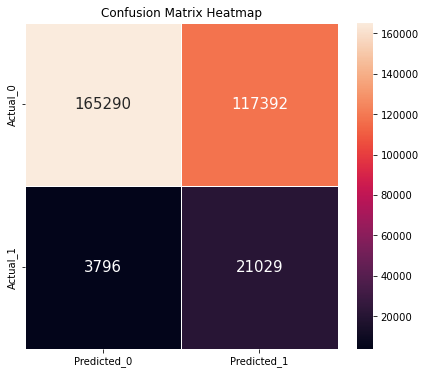

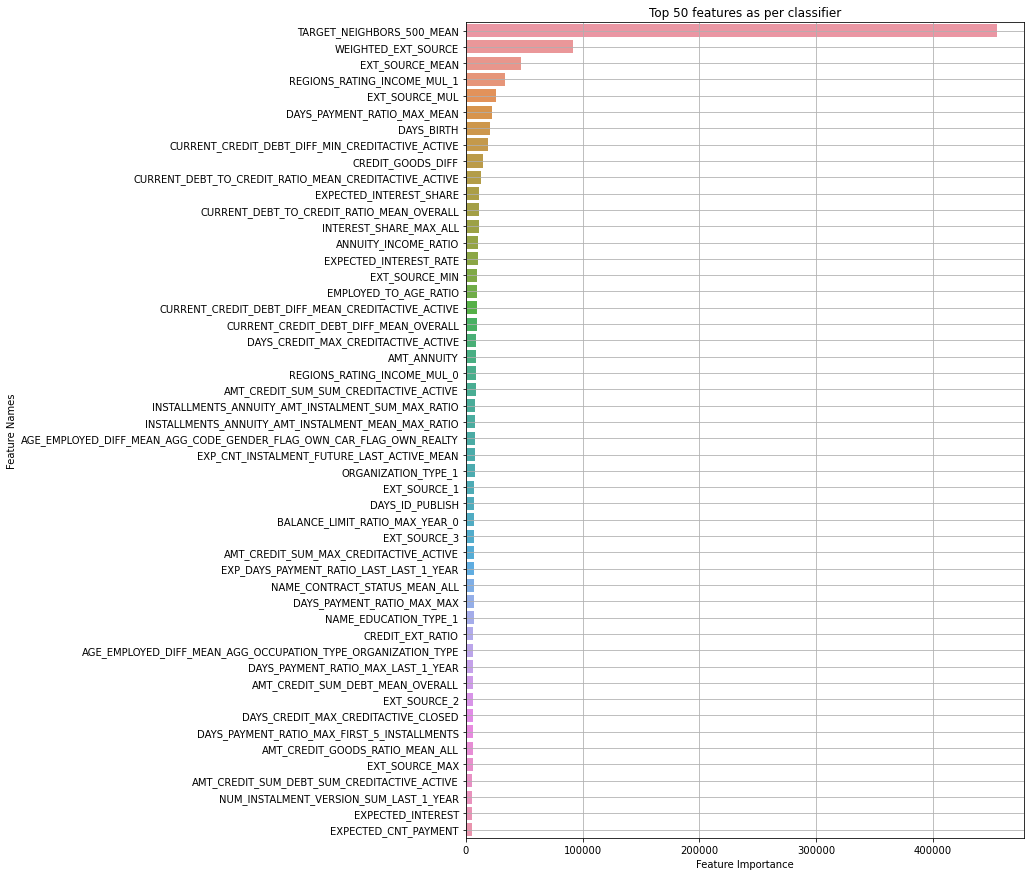

In [75]:
#displaying the results and metrics
lgbm_boosting.results()
#displaying top 50 important features
lgbm_boosting.feat_importances_show(50)

In [76]:
features_with_zero_importances  = lgbm_boosting.feature_importance[lgbm_boosting.feature_importance.gain == 0]

print(f"There are {len(features_with_zero_importances)} features with Zero Gain in LGBMClassifier. They are:\n")
print(features_with_zero_importances.features.values)

There are 47 features with Zero Gain in LGBMClassifier. They are:

['RATE_INTEREST_PRIVILEGED_MEAN_LAST_5'
 'CREDIT_TYPE_Loan for business development_MEAN_OVERALL'
 'CREDIT_TYPE_Mobile operator loan_MEAN_OVERALL' 'NAME_INCOME_TYPE_1'
 'CREDIT_TYPE_Loan for the purchase of equipment_MEAN_OVERALL'
 'CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN_OVERALL'
 'CREDIT_TYPE_Real estate loan_MEAN_OVERALL'
 'EXT_SOURCE_3_MIN_AGG_CODE_GENDER_NAME_FAMILY_STATUS_NAME_INCOME_TYPE'
 'CREDIT_TYPE_Interbank credit_MEAN_OVERALL'
 'CREDIT_TYPE_Another type of loan_MEAN_OVERALL'
 'CREDIT_DURATION_MEAN_OVERALL' 'CURRENCY_currency 1_MEAN_OVERALL'
 'EXT_SOURCE_3_MIN_AGG_FLAG_OWN_CAR_FLAG_OWN_REALTY_NAME_INCOME_TYPE'
 'CREDIT_ACTIVE_Bad debt_MEAN_OVERALL' 'CODE_GENDER_0'
 'CNT_PROLONGED_DURATION_RATIO_MEAN_OVERALL'
 'AMT_ANNUITY_CREDIT_RATIO_MINCREDIT_ACTIVE_REST'
 'AMT_ANNUITY_CREDIT_RATIO_MEANCREDIT_ACTIVE_REST'
 'CREDIT_TYPE_Unknown type of loan_MEAN_OVERALL' 'FLAG_DOCUMENT_17'
 'CURRENCY_c

In [77]:
lgbm_boosting_model_df = pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : lgbm_boosting.test_preds_proba_mean})
lgbm_boosting_model_df['SK_ID_CURR'] = lgbm_boosting_model_df['SK_ID_CURR'].astype(int)
lgbm_boosting_model_df.to_csv('./submissions/LGBM_3folds.csv',index = False)

|        Model     | Private Score | Public Score |
|------------------|---------------|--------------|
| LGBM_3folds      |   0.79358     |   0.79470    |

![title](images/LGBM_3folds.png)

In [78]:
with open('./data/lgbm_imp_feats.pkl','wb') as f:
    pickle.dump(lgbm_boosting.feature_importance, f)
with open('./data/lgbm_cv_preds.pkl', 'wb') as f:
    pickle.dump(lgbm_boosting.cv_preds_proba, f)
with open('./data/lgbm_test_preds.pkl', 'wb') as f:
    pickle.dump(lgbm_boosting.test_preds_proba_mean, f)

<b>Results Discussion</b>

<ul><li>Firstly we see that the LightGBM model performs inferiorly as compared to XGBoost model, as observed from the results of Private Score on Test Data. This is contrary to the fact that LightGBM showed higher AUC value for CV dataset as compared to XGBoost.</li>
    <li>Again the Recall values are quite high, which is a good thing, but the precision values are again not good. The high recall value suggests that most of the actual defaulters are predicted by the model, but the low precision also indicates that model predicts lots of people as defaulters, while they actually aren't.</li>
    <li>We see from the Confusion Matrix that the number of True Positives are lesser in the Case of LightGBM compared to XGBoost. However, the total False Positives are also slightly lesser for LightGBM.</li>
    <li>We also observe that boosting methods show the highest number of True Positives among all the models. This is aided by the high Recall value for these models as well.</li></ul>
    
<ul><b>Feature Importances</b>
    <li>We see that the feature TARGET Mean of 500 neighbors scores quite high as compared to all other features. The difference between gain is very significant. This implies that this feature is indeed a very important feature. </li>
    <li>Similar to all other ensembles, here too, the EXT_SOURCE features score high again.</li>
    <li>One of the interesting high scoring feature for LightGBM is the REGIONS_RATING_INCOME_MUL_1 which is the multiplication of Region Rating of Client with his Income. It has been treated as a categorical feature and has been response encoded, and gives better result than as a numeric feature.</li>
    <li>We also observe that there are around 41 features which had 0 gain in LGBMClassifier for splitting. This means they are not useful for our classifier.
    </ul>

## 2.10 Stacking Classifiers <a class="anchor" id="sec2_10"></a>

In this section, we will try to stack the best classifiers that we have used above, which include Logistic Regression, Linear SVM, Random Forest, XGBoost on reduced features and LightGBM. We will be training a LightGBM Classification Model on the Out-of-fold predictions for all the above classifiers. We will again use the BayesianOptimization Technique for tuning the hyperparameters.

In [86]:
def load_stacking_data(file_directory = '', verbose = True):
    '''
    Objective function to prepare the Stacking Training and Test Data. The training data is the
    Out-Of-Fold predictions of each base learners, and the test data are the predicted probabilities
    on the Test data.
    
    Inputs:
        file_directory: str, default = ''
            The path of directory where the predictions are located. Insert '/' in the end
        verbose: bool, default = True
            Whether to keep verbosity or not
    
    Returns:
        Training stacking data, Test stacking data, Trainig target values
    '''

    if verbose:
        print("Loading the CV (out-of-folds) and Test Predictions from Base Models...")
        start = datetime.now()
        
    global sgd_lr_l2_cv, sgd_svm_cv, rf_cv, xgb_cv, lgbm_cv
    global sgd_lr_l2_test, sgd_svm_test, rf_test, xgb_test, lgbm_test
    
    with open(file_directory + 'SGD_LR_L2_Penalty_CV_Preds.pkl', 'rb') as f:
        sgd_lr_l2_cv = pickle.load(f)
    with open(file_directory + 'SGD_Linear_SVM_CV_Preds.pkl', 'rb') as f:
        sgd_svm_cv = pickle.load(f)
    with open(file_directory + 'Random_Forest_CV_Preds.pkl', 'rb') as f:
        rf_cv = pickle.load(f)
    with open(file_directory + 'xgb_cv_preds_600feats.pkl', 'rb') as f:
        xgb_cv = pickle.load(f)
    with open(file_directory + 'lgbm_cv_preds.pkl', 'rb') as f:
        lgbm_cv = pickle.load(f)

    #loading the Predicted Probabilities of Test Set
    sgd_lr_l2_test = pd.read_csv('./submissions/' + 'SGD_LR_L2_penalty.csv')['TARGET']
    sgd_svm_test = pd.read_csv('./submissions/' + 'SGD_Linear_SVM.csv')['TARGET']
    rf_test = pd.read_csv('./submissions/' + 'Random_Forest_cv0.csv')['TARGET']
    xgb_test = pd.read_csv('./submissions/' + 'XGBoost_600_features.csv')['TARGET']
    lgbm_test = pd.read_csv('./submissions/' + 'LGBM_3folds.csv')['TARGET']
    
    if verbose:
        print("Making the Training and Test Dataset for Stacking...")
    #defining the training and test datasets
    stack_train = pd.DataFrame(np.stack([sgd_lr_l2_cv, sgd_svm_cv, rf_cv, xgb_cv, lgbm_cv], axis = 1), 
                              columns = ['SGD_LR_L2', 'SGD_SVM', 'RF', 'XGB', 'LGBM'])
    stack_target = target_train.copy()
    stack_test = pd.concat([sgd_lr_l2_test, sgd_svm_test, rf_test, xgb_test, lgbm_test], axis = 1)
    stack_test.columns = ['SGD_LR_L2', 'SGD_SVM', 'RF', 'XGB', 'LGBM']
    
    if verbose:
        print("Done.")
        print(f"Time elapsed = {datetime.now() - start}")
        print(f"Shape of stacking training data = {stack_train.shape}")
        print(f"Shape of stacking test data = {stack_test.shape}")
        print(f"Shape of stacking training class labels = {stack_target.shape}")
        
    return stack_train, stack_test, stack_target

In [87]:
stack_train, stack_test, stack_target = load_stacking_data(file_directory='./data/')

Loading the CV (out-of-folds) and Test Predictions from Base Models...
Making the Training and Test Dataset for Stacking...
Done.
Time elapsed = 0:00:00.157002
Shape of stacking training data = (307507, 5)
Shape of stacking test data = (48744, 5)
Shape of stacking training class labels = (307507,)


In [88]:
stack_train.head()

,SGD_LR_L2,SGD_SVM,RF,XGB,LGBM
0,0.894036,0.362628,0.596951,0.191602,0.232832
1,0.084533,0.009465,0.134516,0.011669,0.013201
2,0.314510,0.039542,0.200077,0.015869,0.017512
3,0.273914,0.033335,0.166268,0.024180,0.022110
4,0.473407,0.067371,0.290049,0.065830,0.055259


**Bayesian Optimization**

In [20]:
def lgbm_stacker_optimization(num_leaves, max_depth, min_split_gain, min_child_weight,
                             min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Function for Bayesian Optimization of LightGBM's Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.
    
    Inputs: Hyperparamters to be tuned.
        num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda
        
    Returns:
        CV ROC-AUC Score
    '''
    
    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : 8956
    }
    stratified_cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 96)
    
    cv_preds = np.zeros(stack_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(stack_train, stack_target):

        x_tr = stack_train.iloc[train_indices]
        y_tr = stack_target.iloc[train_indices]
        x_cv = stack_train.iloc[cv_indices]
        y_cv = stack_target.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                eval_metric='auc', verbose = False, early_stopping_rounds=200)

        cv_preds[cv_indices] = lgbm_clf.predict_proba(x_cv, num_iteration = lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(stack_target, cv_preds)

In [21]:
bopt_stacking = BayesianOptimization(lgbm_stacker_optimization, {'num_leaves' : (2,50),
                                                   'max_depth' : (2,6),
                                                   'min_split_gain' : (0, 0.5),
                                                   'min_child_weight' : (1,80),
                                                   'min_child_samples' : (5,80),
                                                   'subsample' : (0.001,1),
                                                   'colsample_bytree' : (0.2,1),
                                                   'reg_alpha' : (0.00001, 0.3),
                                                   'reg_lambda' : (0.00001, 0.3)},
                                 random_state = 6569)

bayesian_optimization = bopt_stacking.maximize(n_iter = 10, init_points = 10)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8062   |  0.7955   |  5.417    |  44.35    |  38.21    |  0.4826   |  19.51    |  0.06595  |  0.05161  |  0.5286   |
|  2        |  0.8063   |  0.7451   |  4.236    |  47.4     |  58.14    |  0.1048   |  47.96    |  0.2365   |  0.249    |  0.7261   |
|  3        |  0.8065   |  0.6329   |  4.483    |  32.69    |  24.78    |  0.3669   |  2.316    |  0.09315  |  0.09452  |  0.4668   |
|  4        |  0.8045   |  0.4877   |  4.83     |  70.16    |  64.09    |  0.2487   |  22.81    |  0.2672   |  0.01726  |  0.4483   |
|  5        |  0.7801   |  0.3603   |  5.12     |  68.84    |  64.73    |  0.1149   |  9.906    |  0.1364   |  0.05073  |  0.1665   |
|  6        |  0.7778   |  0.273    |  2.604    |  26.55    | 

In [22]:
#extracting the best parameters
target_values = []
for result in bopt_stacking.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print("Best Hyperparameters obtained are:\n")
print(best_params)

Best Hyperparameters obtained are:

{'colsample_bytree': 0.777005917777368, 'max_depth': 3.4661509471225993, 'min_child_samples': 42.65047945139628, 'min_child_weight': 9.223836586454116, 'min_split_gain': 0.07297767759639462, 'num_leaves': 29.918608004586297, 'reg_alpha': 0.015583802542867243, 'reg_lambda': 0.21883161475419755, 'subsample': 0.29967715403460243}


**Training on Optimized Hyper-parameters**

In [89]:
params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : 30,
        'max_depth' : 4,
        'min_split_gain' : 0.07297767759639462,
        'min_child_weight' : 9.223836586454116,
        'min_child_samples' : 43,
        'subsample': 0.29967715403460243,
        'subsample_freq' : 1,
        'colsample_bytree' : 0.777005917777368,
        'reg_alpha' : 0.015583802542867243,
        'reg_lambda' : 0.21883161475419755,
        'verbosity' : -1,
        'seed' : 266
    }
stacker_boosting = Boosting(stack_train, stack_target, stack_test, params, random_state = 96, num_folds = 4)
stacker_boosting.train(booster = 'lightgbm')

Fitting the lightgbm on Training Data with 4 fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation

	Fold Number 1

[400]	training's auc: 0.808608	training's binary_logloss: 0.230945	valid_1's auc: 0.804848	valid_1's binary_logloss: 0.231659
[800]	training's auc: 0.809359	training's binary_logloss: 0.229169	valid_1's auc: 0.804915	valid_1's binary_logloss: 0.230363

	Fold Number 2

[400]	training's auc: 0.808453	training's binary_logloss: 0.230887	valid_1's auc: 0.805412	valid_1's binary_logloss: 0.231861

	Fold Number 3

[400]	training's auc: 0.80782	training's binary_logloss: 0.231023	valid_1's auc: 0.807424	valid_1's binary_logloss: 0.231547
[800]	training's auc: 0.80851	training's binary_logloss: 0.229263	valid_1's auc: 0.807504	valid_1's binary_logloss: 0.230096

	Fold Number 4

[400]	training's auc: 0.807416	training's binary_logloss: 0.231241	valid_1's auc: 0.808646	valid_1's binary_logloss: 0.231023
Done.
Time elapsed = 0:00:52.946849


Train Results:

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.027262015818079285

	ROC-AUC Score = 0.8068788232594093
	Precision Score = 0.19050680825909755
	Recall Score = 0.7399798590130916
CV Results:
	ROC-AUC Score = 0.8049454509653551
	Precision Score = 0.1066937629256782
	Recall Score = 0.9580261832829808
Confusion, Precision and Recall Matrix on CV data:


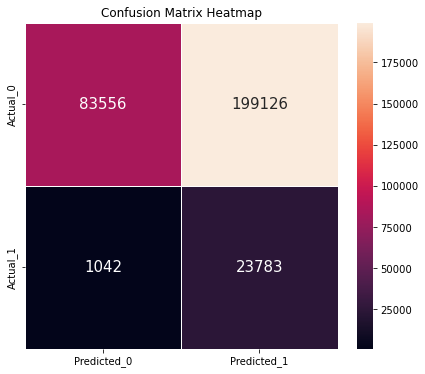

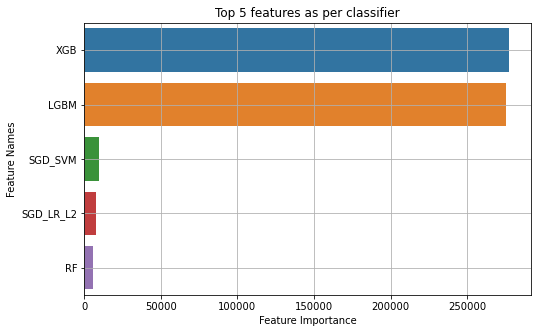

In [90]:
#displaying the results and metrics
stacker_boosting.results()
#displaying top 50 important features
stacker_boosting.feat_importances_show(5, figsize = (8,5))

In [91]:
stacking_model_df = pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : stacker_boosting.test_preds_proba_mean})
stacking_model_df['SK_ID_CURR'] = stacking_model_df['SK_ID_CURR'].astype(int)
stacking_model_df.to_csv('./submissions/LGBM_Stacker_4_Fold.csv',index = False)

|        Model        | Private Score | Public Score |
|---------------------|---------------|--------------|
| LGBM_Stacker_4_Fold |   0.79494     |   0.79702    |

![title](images/LGBM_Stacker_4_Fold.png)

<b>Results Discussion</b>

<ul><li>From the stacking classifier, we see that the both the CV and Private Score obtained are the higher than all the base classifiers. </li>
    <li>We also observe that the recall value is very high, but the Precision value has gone down even further.</li>
    <li>This stacking model, however, performs worse than a single XGB model, this could be due to the low number of base models. Also the base classifiers might be correlated with each other too, so that may also have caused low performance with stacking.</li>
    <li>From the Feature Importance of LightGBM, we see that the LGBM base model's predictions score the highest among all the base classifiers, which is followed by XGB's predictions. The least importance comes out for the Random Forest Classifier's predictions.</li></ul>
   

## 2.11 Blending of Predictions  <a class="anchor" id="sec2_11"></a>

Based on the feature importances obtained from the Stacking Classifier, we will now try to blend the predictions of all classifiers, in a ratio proportion to their feature importances from above.

In [92]:
#getting the feature importance from stacking classifier
feat_imp_gain_stacking = stacker_boosting.feature_importance
#normalizing the gain values to lie between 0 to 1
feat_imp_gain_stacking.gain = feat_imp_gain_stacking.gain / sum(feat_imp_gain_stacking.gain)
print("Normalized Gain Value as per Stacking Classifier for each base models are:")
display(feat_imp_gain_stacking)

Normalized Gain Value as per Stacking Classifier for each base models are:


,features,gain
4,XGB,0.481779
0,LGBM,0.478200
3,SGD_SVM,0.016968
2,SGD_LR_L2,0.013509
1,RF,0.009545


Results on CV Dataset:

The best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = 0.08695461862946152

ROC-AUC Score CV = 0.8063421157831652
Precison Score CV = 0.1875164657006789
Recall Score CV = 0.7454582074521652
Confusion Matrix of CV data:


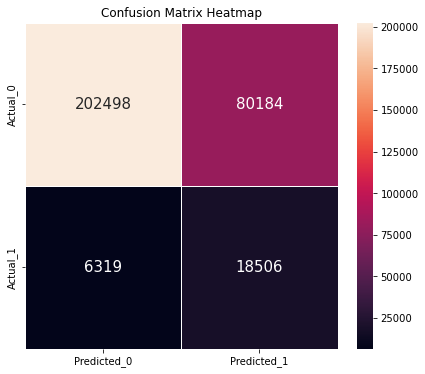

In [93]:
blended_cv_preds = sgd_lr_l2_cv * 0.021874 + sgd_svm_cv * 0.024588 + rf_cv * 0.011525 + xgb_cv * 0.202057 + lgbm_cv * 0.739955
blended_test_preds = sgd_lr_l2_test * 0.021874 + sgd_svm_test * 0.024588 + rf_test * 0.011525 + xgb_test * 0.202057 + lgbm_test * 0.739955

#tuning the threshold again
fpr, tpr, threshold = roc_curve(target_train, blended_cv_preds)
j = tpr - fpr
best_threshold = threshold[np.argmax(j)]
#calculating the metrics values
print("Results on CV Dataset:")
print("="*100)
print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {best_threshold}\n")
print(f"ROC-AUC Score CV = {roc_auc_score(target_train, blended_cv_preds)}")
print(f"Precison Score CV = {precision_score(target_train, np.where(blended_cv_preds >= best_threshold, 1, 0))}")
print(f"Recall Score CV = {recall_score(target_train, np.where(blended_cv_preds >= best_threshold, 1, 0))}") 

print('=' * 100)
print("Confusion Matrix of CV data:")
conf_mat = confusion_matrix(target_train, np.where(blended_cv_preds >= best_threshold, 1, 0))
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (7,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
plt.show()
print("="*100)

In [94]:
blending_model_df = pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : blended_test_preds})
blending_model_df['SK_ID_CURR'] = blending_model_df['SK_ID_CURR'].astype(int)
blending_model_df.to_csv('Blending_all.csv',index = False)

|      Model      | Private Score | Public Score |
|-----------------|---------------|--------------|
| Blending_all    |   0.79650     |   0.79910    |

![title](images/Blending_all.png)

<b>Results Discussion</b>

<ul>
<li>We see that this blended model shows the second highest CV ROC-AUC among all models.</li>
<li>It was a rather more heuristic process, as we just used the importance of each model obtained from Stacking Classifier as its weight to blend, and it turns out to give the best ROC-AUC among all the models so far, on Test Dataset.</li>
<li>However, the Recall and Precision values are not that good. This might require rather more rigorous threshold tuning to improve the results a bit more.</li>
    </ul>

# 3 Results Summarization and Conclusion <a class="anchor" id="sec3"></a>

In [95]:
results_df = pd.DataFrame([['Random Model', np.round(0.502074521651561, 5), '-', np.round(0.5019228859165302, 5), '-', 0.49735, 0.48234],
                            ['Dominant Class', 0.0, '-', np.round(0.5003946699208937, 5), '-', 0.49054, 0.50009],
                            ['SGD LogisticRegression L2', np.round(0.7383282980866063,5), np.round(0.7203222557905338,5), 
                               np.round(0.7974418830512477,5), np.round(0.7908099381800479,5), 0.77894, 0.78355],
                            ['SGD Linear SVM', np.round(0.731238670694864, 5), np.round(0.723423967774421, 5), 
                                      np.round(0.7982204969030176, 5), np.round(0.7917099696602703, 5), 0.77924, 0.78397],
                            ['RandomForestClassifier', np.round(0.7992749244712991, 5), np.round(0.7203625377643504, 5),
                                      np.round(0.8319575125937456, 5), np.round(0.7775217809573731, 5), 0.76396, 0.77103],
                            ['XGBoostClassifier', np.round(0.7961329305135951, 5), np.round(0.8660624370594159, 5), 
                                      np.round(0.868035603552344, 5), np.round(0.8015933814027488, 5), 0.79733, 0.79921],
                            ['XGBoostClassifier - 600 Features', np.round(0.7829607250755287, 5), np.round(0.8645317220543807, 5), 
                                      np.round(0.8602796863474593, 5), np.round(0.8012951862548242, 5), 0.79744, 0.79768],
                            ['LightGBMClassifier', np.round(0.8279556898288016, 5), np.round(0.8223967774420947, 5), 
                                      np.round(0.9165567214393182, 5), np.round(0.8059107038548963, 5), 0.79358, 0.79470],
                            ['StackingClassifier', np.round(0.7245115810674723, 5), np.round(0.9394964753272911, 5),
                                      np.round(0.8086869294476866, 5), np.round(0.806389949291142, 5), 0.79494, 0.79702],
                            ['Blending Results', '-', np.round(0.7270493454179254, 5), '-', np.round(0.806019136238926, 5),
                                      0.79650, 0.79910]], 
                          columns = ['Model', 'Train Recall', 'CV Recall', 'Train ROC-AUC', 'CV ROC-AUC', 
                                     'Private Score (ROC-AUC)', 'Public Score (ROC-AUC)'], index = list(range(1,11)))

display(results_df)

,Model,Train Recall,CV Recall,Train ROC-AUC,CV ROC-AUC,Private Score (ROC-AUC),Public Score (ROC-AUC)
1,Random Model,0.50207,-,0.50192,-,0.49735,0.48234
2,Dominant Class,0.0,-,0.50039,-,0.49054,0.50009
3,SGD LogisticRegression L2,0.73833,0.72032,0.79744,0.79081,0.77894,0.78355
4,SGD Linear SVM,0.73124,0.72342,0.79822,0.79171,0.77924,0.78397
5,RandomForestClassifier,0.79927,0.72036,0.83196,0.77752,0.76396,0.77103
6,XGBoostClassifier,0.79613,0.86606,0.86804,0.80159,0.79733,0.79921
7,XGBoostClassifier - 600 Features,0.78296,0.86453,0.86028,0.8013,0.79744,0.79768
8,LightGBMClassifier,0.82796,0.8224,0.91656,0.80591,0.79358,0.79470
9,StackingClassifier,0.72451,0.9395,0.80869,0.80639,0.79494,0.79702
10,Blending Results,-,0.72705,-,0.80602,0.79650,0.79910


From the above results, we observe that the:
<ul><li>The highest Cross-Validation Recall value was obtained for Stacking Classifier Model, which is then followed by XGBoostClassifier Model.</li>
    <li>The Highest CV ROC-AUC was observed for StackingClassifier, followed by Blended Model, then LightGBM and XGBoost. They all are pretty close to each other.</li>
    <li>The best Private Score (ROC-AUC) was obtained for XGBoostClassifier-600 features Model</li>
    <li>Overall the Boosting Models out-performed the other models by a margin, as can be seen from both the CV and Private Score. However, the linear models like Logistic Regression and Linear SVM performed better thatn RandomForest Ensemble. This could be due to the high dimensionality of the dataset</li></ul>